In [11]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [12]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import seaborn as sns
#import itertoocls
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,accuracy_score
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,8
from statsmodels.tsa.stattools import acf, pacf 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.utils import check_array
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from pmdarima.arima import auto_arima

%matplotlib inline

In [13]:
energy_data = pd.read_csv('energy_dataset.csv') #specify name of the file 
weather_data = pd.read_csv('weather_features.csv')

In [14]:
#remove columns that are not useful in the dataset--does not contain any values
energy_data = energy_data.drop(columns = ['generation fossil coal-derived gas',
                                          'generation fossil oil shale','generation fossil peat','generation geothermal',
                                          'generation hydro pumped storage aggregated',
                                          'generation marine','generation wind offshore','forecast wind offshore eday ahead'])

In [15]:
#Explore columns datatypes in both energy and weather dataset

properties_energy = energy_data.describe()
properties_weather = weather_data.describe()

energy_data.columns
energy_data.dtypes

weather_data.columns
weather_data.dtypes

energy_data.shape
weather_data.shape


(178396, 17)

In [16]:
#Check for missing values in energy dataset

energy_data.columns[energy_data.isna().any()].tolist()
energy_data.isna().sum().sum() #overall missing values in all columns

print(energy_data.isna().sum()) #Missing values in each column count


time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0


In [17]:
#Imputing with the interpolation method time 
#Validating if we have a daily mean for these missing rows

for i in energy_data.columns[energy_data.isna().any()].tolist():
    print(i , energy_data[energy_data[i].isnull()].index.tolist() , sep ='-----')
    
#From the analysis it is clear that there is atleast 
#One hourly data entry for days with missing values
#Since we are going to predict the forecast price, we see there is no missing values in the 
#Forecast values for both price and load.
#If we want to use the previous day actual price also as a regressor for predicting day ahead price 
#We still have no missing values for the actual price.

#To do this we have to convert the data type of the time column from object to datetime
energy_data['time'] = energy_data['time'].str.slice(start=0,stop=19)
energy_data['time'] = pd.to_datetime(energy_data.time,format = '%Y-%m-%d %H:%M:%S')

#Set the index as the time column -- equally spaced -- so could use linear interpolation as well
#no missing data in the time column
energy_data = energy_data.set_index(['time'])

#energy_data['generation biomass'].resample('D').mean().head(99)
#energy_data['generation biomass'].interpolate(method='time', inplace=True)
for i in energy_data.columns[energy_data.isna().any()].tolist():
   energy_data[i].interpolate(method='time', inplace=True)
#Missing values replaced   
energy_data.reset_index(level=0, inplace=True)
#Adding year,month,day and hour columns to analyze the forecasts for these frequencies explicitly
energy_data['year'] = energy_data['time'].dt.year
energy_data['month'] = energy_data['time'].dt.month
energy_data['day'] =  energy_data['time'].dt.day
energy_data['hour'] = energy_data['time'].dt.hour
#Checking for weekend/weekeday -- to understand if more load consumed on weekedays
def checkweekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0    
energy_data['weekend']=energy_data['time'].apply(checkweekend)
#Finding duplicates
#Select duplicate rows except first occurrence based on all columns
energy_duplicates = energy_data[energy_data.duplicated()]
# duplicates in the energy dataset
energy_data_corr = energy_data.drop(columns = ['time','year','month','day','hour'])
corr_matrix_energy = energy_data_corr.corr()


generation biomass-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 16612, 30896]
generation fossil brown coal/lignite-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 30896]
generation fossil gas-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 30896]
generation fossil hard coal-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 30896]
generation fossil oil-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 13391, 30896]
generation hydro pumped storage consumption-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 13341, 15982, 30896]
generation hydro run-of-river and poundage-----[99, 108, 109, 110, 111, 112, 113, 451, 452, 643, 661, 2528, 2708, 3968, 6586, 8049, 12672, 13341, 30896]
generation hydro water reservoir----

In [18]:
#Weather dataset
#Check for missing values in energy dataset

weather_data.columns[weather_data.isna().any()].tolist()
weather_data.isna().sum().sum() #overall missing values in all columns

print(weather_data.isna().sum()) #Missing values in each column count

#Duplicate rows
#To get the duplicate rows for each city group by city name and then remove the duplicates
#In each city becuase we shouldnt consider the timeseries of different cities as duplicates
rows_weather = weather_data.groupby('city_name').agg('count')
print(rows_weather['dt_iso'])

#There are duplicates in the weather dataset
#There are 4 days in october in all 4 years with daylight savings additional hour
#Captured in tz part
#Adding additional column to remove only actual duplicates since the hour value is same in 
#These 4 days 
weather_data['time'] = pd.to_datetime(weather_data['dt_iso'], utc=True, infer_datetime_format=True)
weather_data = weather_data.set_index('time')

#Energy rows are 35064
#Need to remove duplicates in each city and then merge the 2 datasets to utilize weather features 
#in predicting as well

weather_data = weather_data.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('dt_iso')

weather_data = weather_data.reset_index()
#Drop the time column
#weather_data = weather_data.drop(columns='time')

#convert the data type of the time column from object to datetime
weather_data['dt_iso'] = weather_data['dt_iso'].str.slice(start=0,stop=19)
weather_data['dt_iso'] = pd.to_datetime(weather_data.dt_iso, format = '%Y-%m-%d %H:%M:%S')

#Monthly and Daily weather conditions clould impact power consumption
#Adding these frequencies and this can be grouped by cities on monthly, daily basis to
#understand the impact 

weather_data['year'] = weather_data['dt_iso'].dt.year
weather_data['month'] = weather_data['dt_iso'].dt.month
weather_data['day'] =  weather_data['dt_iso'].dt.day
weather_data['hour'] = weather_data['dt_iso'].dt.hour

#Now we have the same rows in both energy and weather dataset
#Exploratory analysis
#Validating our different hypothesis


dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64
city_name
 Barcelona    35476
Bilbao        35951
Madrid        36267
Seville       35557
Valencia      35145
Name: dt_iso, dtype: int64


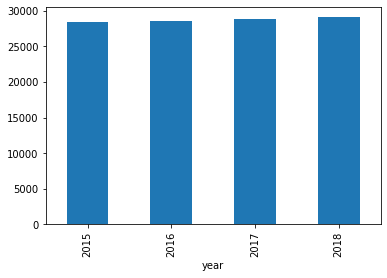

In [19]:
#1) Power consumption - is there a difference in the overall yearly consumption

energy_data.groupby('year')['total load forecast'].mean().plot.bar()


([<matplotlib.axis.XTick at 0x1eb0025feb8>,
 <a list of 11 Text xticklabel objects>)

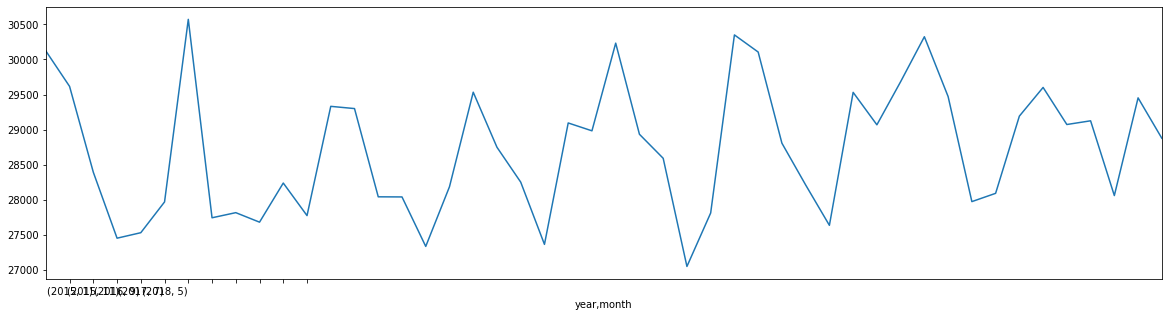

In [20]:
#There does not seem to be much

temp = energy_data.groupby(['year','month'])['total load forecast'].mean()
temp.plot(figsize=(20,5))
plt.xticks(range(min(energy_data['month']), max(energy_data['month'])))


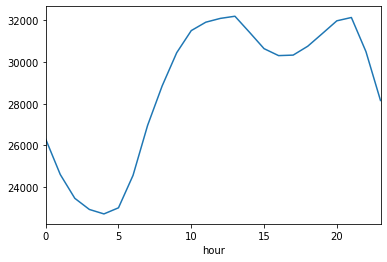

In [21]:
#2)Peak hours more power consumption - Identifying the peak hours
energy_data.groupby('hour')['total load forecast'].mean().plot.line()

#From the graph we can see that there is a leap in the power consumption from 6 hours until 13 hours
#Then it slowly decreases from 15 hours to 17 hours after which it steadily increases till 21 hours 
#and gradually decreases from 22 hours to 5 hours 
#From this we can classify the peak hourly consumption is from 6 hours to 15 hours and 
#From 17 hours till 21 hours


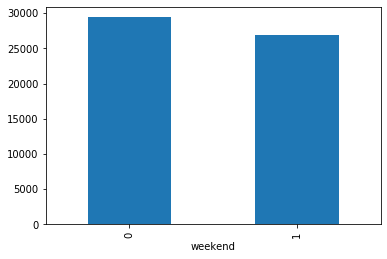

In [22]:
#3)Weekdays more power consumption
energy_data.groupby('weekend')['total load forecast'].mean().plot.bar()

#From the graph we can see more power consumption is on weekdays since most of the comapnies,
#factories etc., work on weekdays and will consume more electricity
#This validates our hypothesis


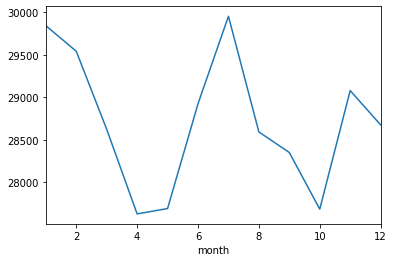

In [23]:
#4)Power consumption will be more during severe winters and summers
#check for seasonal patterns monthly in power consumption

energy_data.groupby('month')['total load forecast'].mean().plot.line()

#Clearly we can see that consumption is more during winters and summers and drops 
#considerably during moderate weather conditions

#this can further be validated by exploring the weather dataset
#Impact of weather conditions on power consumption 


In [24]:
aggaregateweather = weather_data.groupby('city_name').mean()

#Coorelation matrix for the weather dataset to check if any variables can be dropped from
#Analysis if found to have linear trends


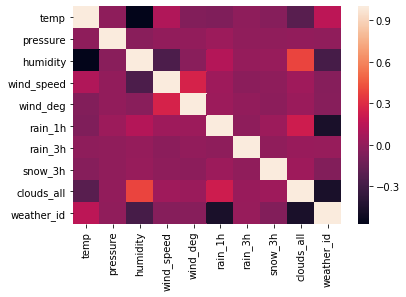

In [25]:
weather_data_wt_city = weather_data.drop(columns=['temp_min','temp_max','dt_iso','time','city_name','weather_main','weather_description','weather_icon','year','month','day','hour'])
weather_data_wt_city = weather_data_wt_city[weather_data_wt_city.columns].astype(float)
corr_matrix = weather_data_wt_city.corr()

sns.heatmap(weather_data_wt_city.corr())

#From the coorelation matrix, there doesnt seem to be a strong linear
#trend amongst these variables 


C:\Users\sanna\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


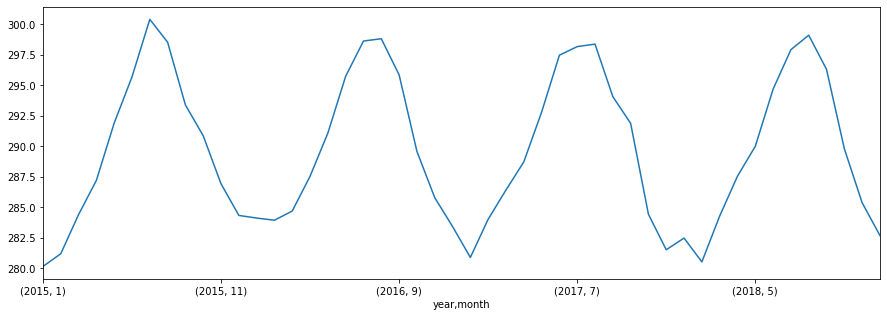

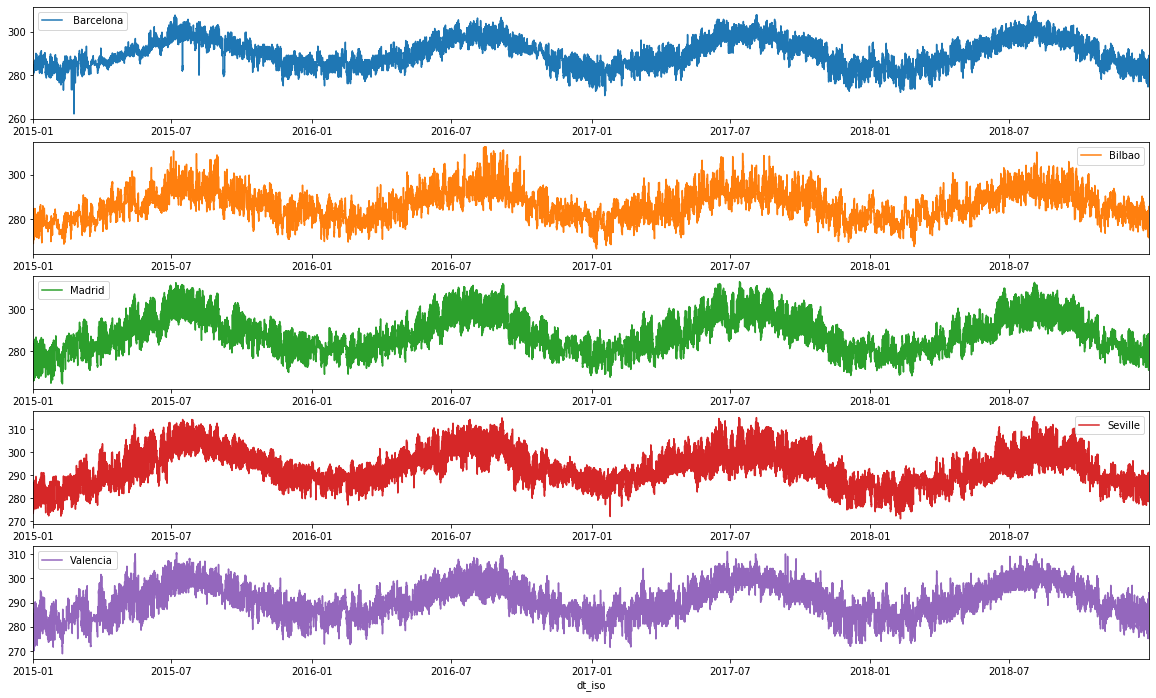

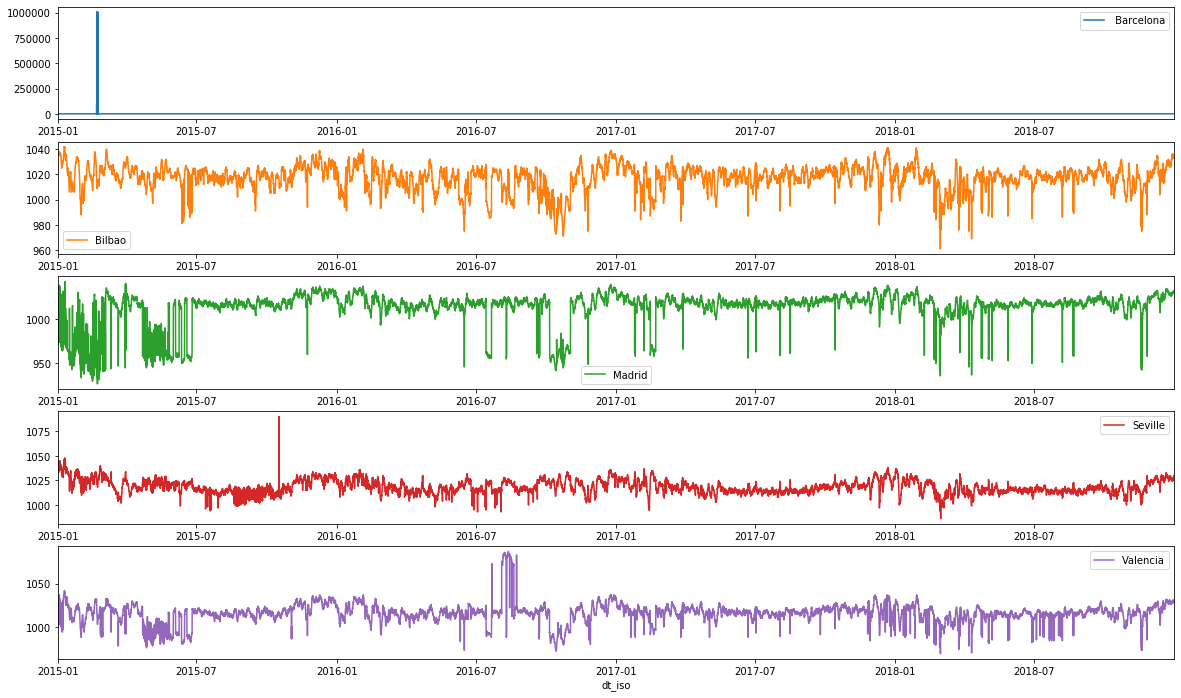

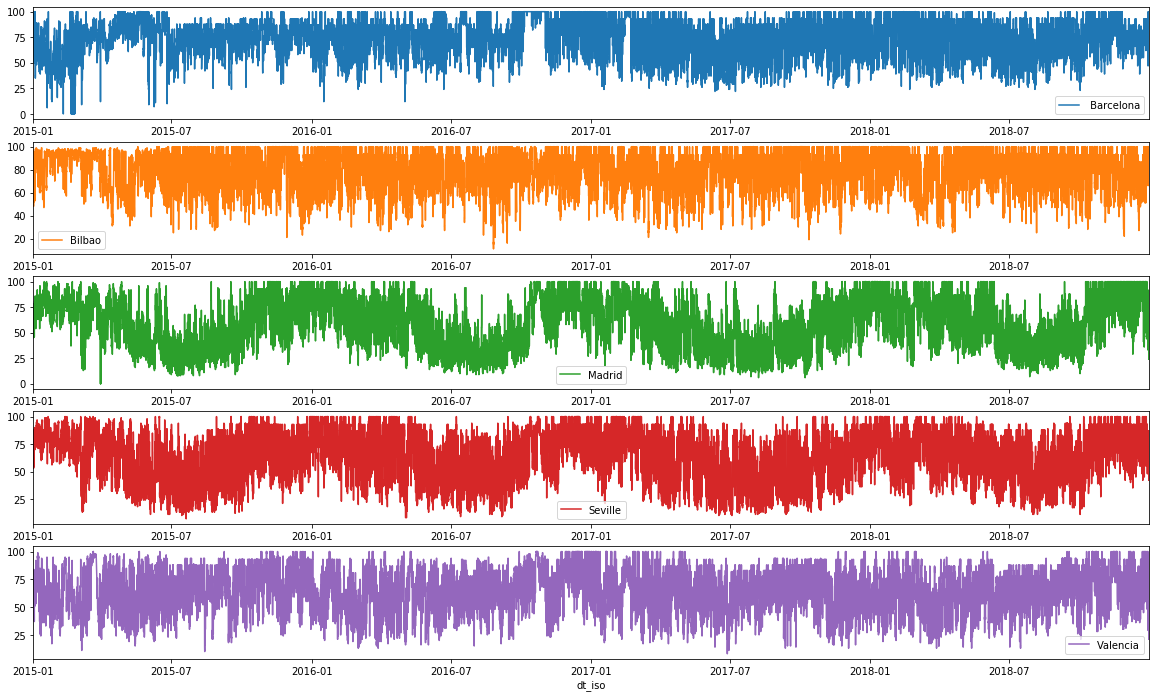

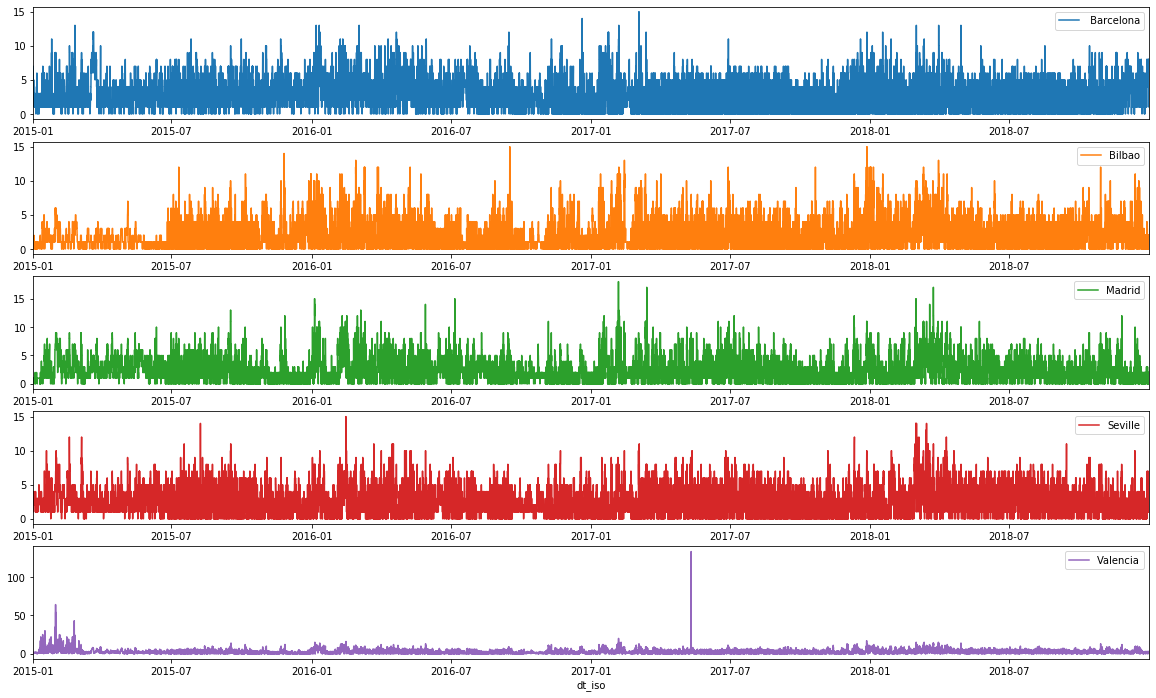

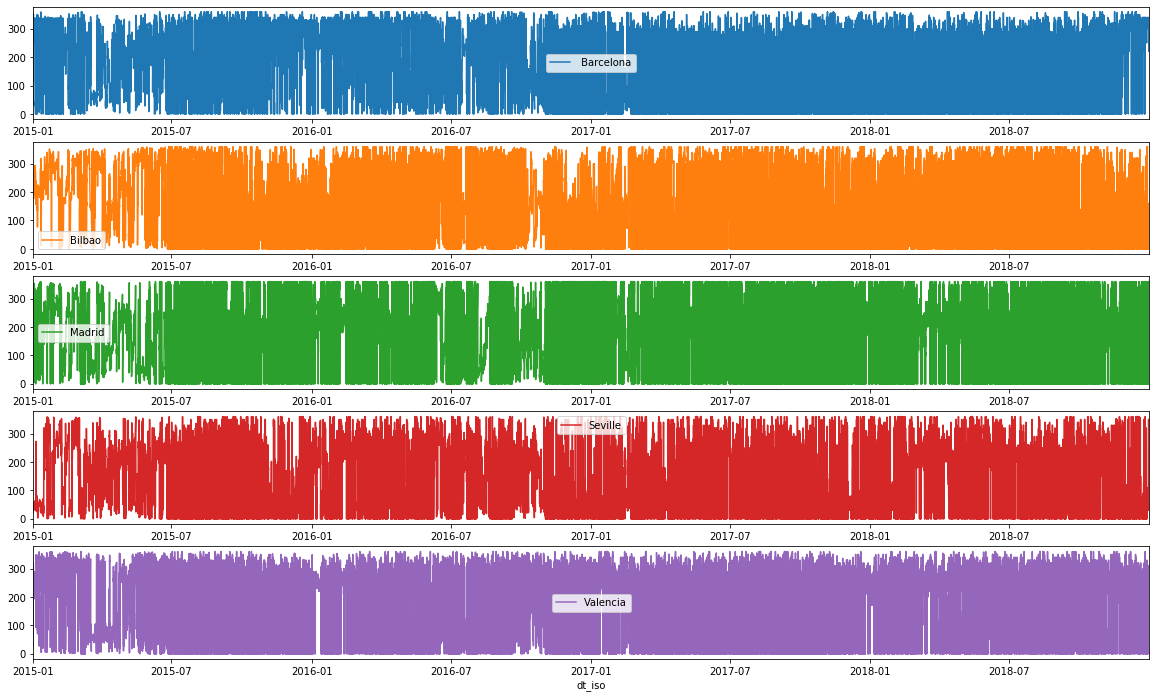

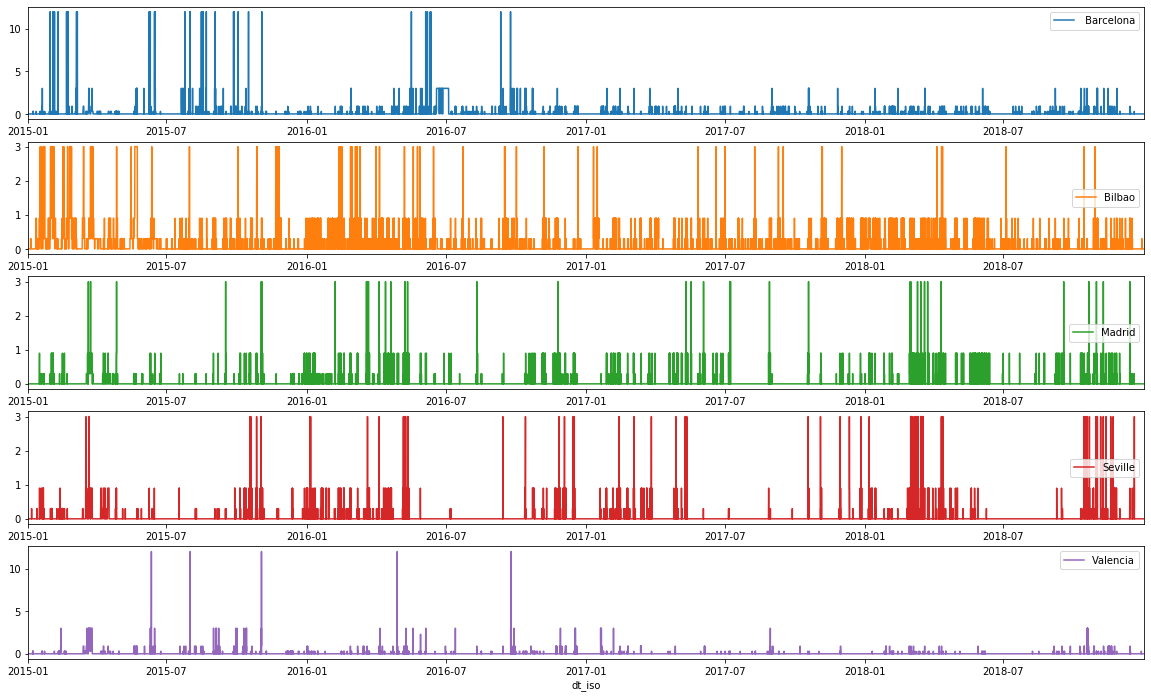

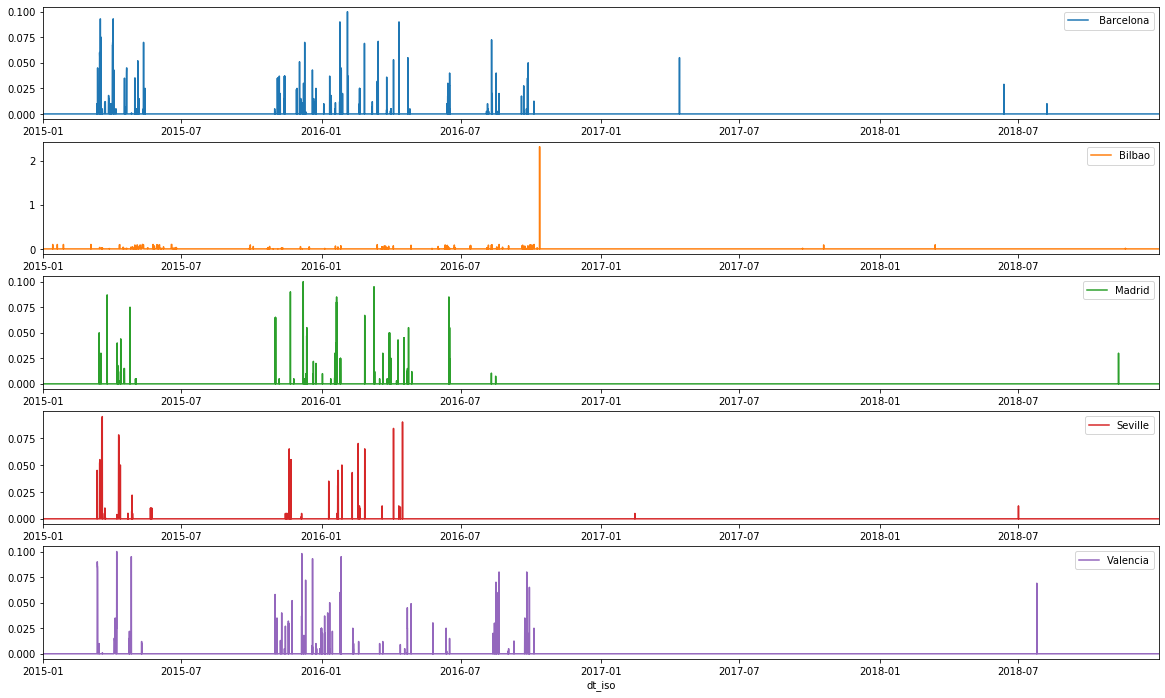

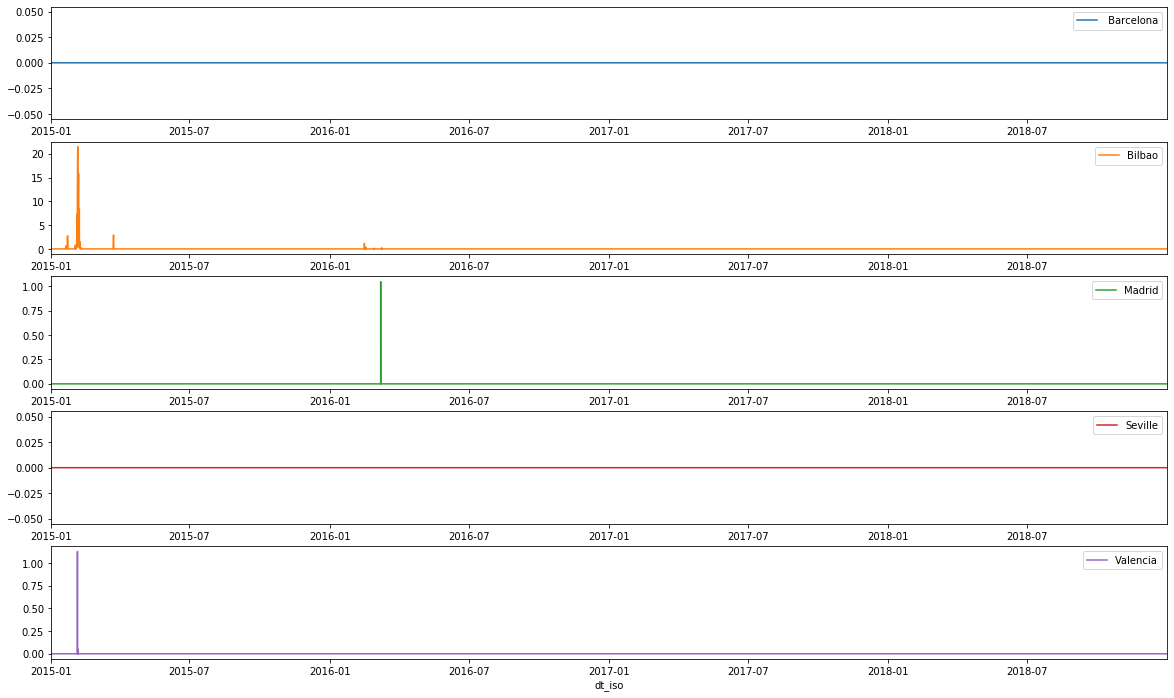

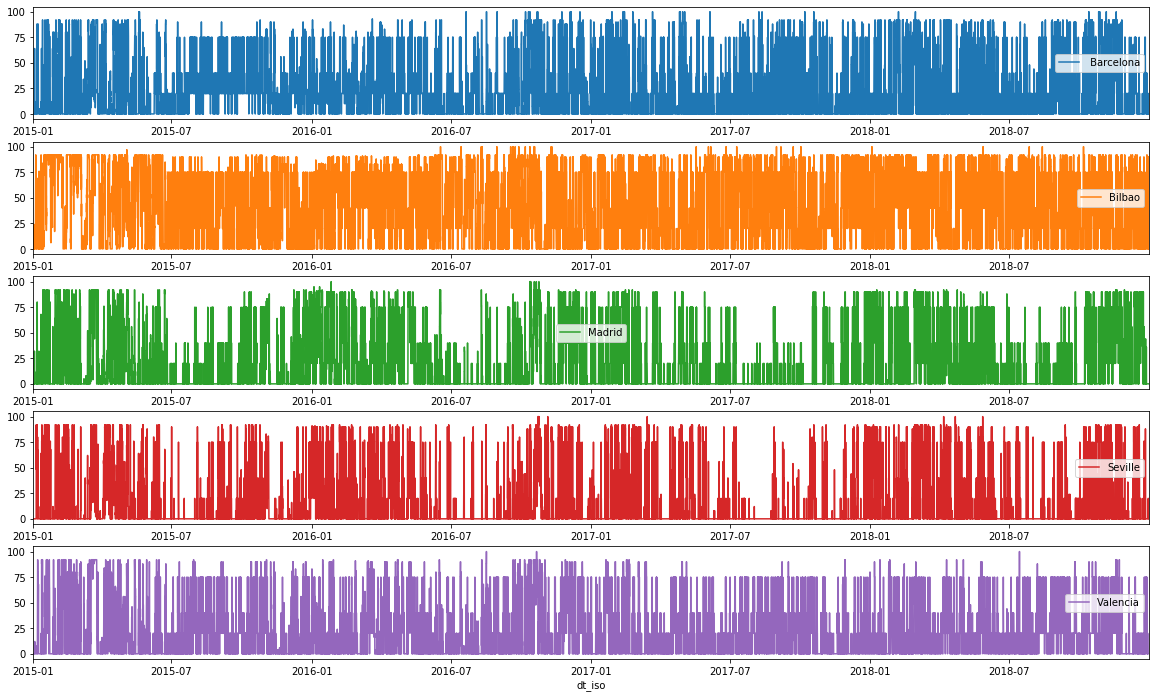

In [26]:
#Analyzing them separately for each cities 

tempw = weather_data.groupby(['year','month'])['temp'].mean()
tempw.plot(figsize=(15,5))

weather_by_city = weather_data.pivot_table('temp', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()

weather_by_city = weather_data.pivot_table('pressure', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()
#The pressure graph clearly shows some outliers that has to be explored further for Barcelona

weather_by_city = weather_data.pivot_table('humidity', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()

weather_by_city = weather_data.pivot_table('wind_speed', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()
#The windspeed graph clearly shows some outliers that has to be explored further for Valencia

weather_by_city = weather_data.pivot_table('wind_deg', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()

weather_by_city = weather_data.pivot_table('rain_1h', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()
#Rain_1h for Barcelona and Valencia

weather_by_city = weather_data.pivot_table('rain_3h', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()
#Bilbao for rain_3h

weather_by_city = weather_data.pivot_table('snow_3h', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()
#Bilbao snow

weather_by_city = weather_data.pivot_table('clouds_all', index='dt_iso', columns='city_name', aggfunc='mean')
fig, ax = plt.subplots(figsize=(20, 12))
weather_by_city.plot(ax=ax, subplots=True)
plt.show()


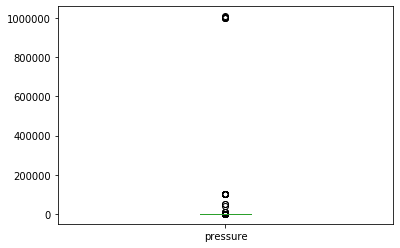

In [27]:
#Eliminating outliers for pressure,windspeed,rain_1h,rain_3h,snow
 
weather_data_exp_pressure = weather_data['pressure']
weather_data_exp_pressure = weather_data_exp_pressure.plot.box()
#From the box plot we can see the outliers


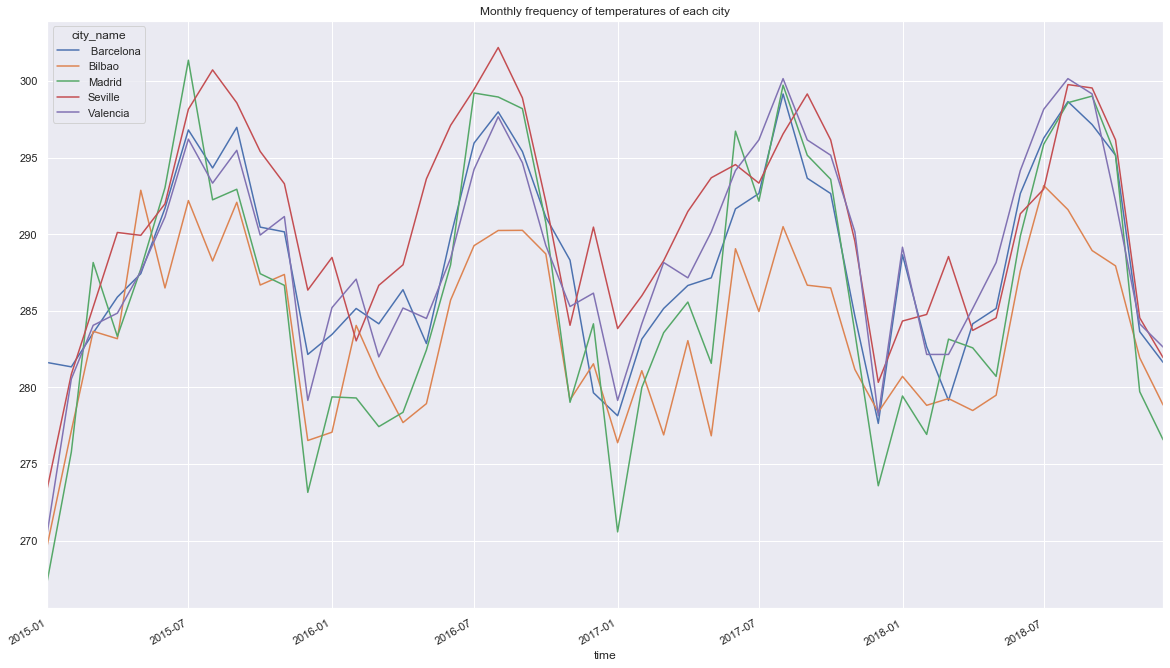

In [28]:
# Plot the temperature (monthly frequency) for all cities
temp_by_city = weather_data.pivot_table('temp', index='time', columns='city_name', aggfunc='mean')

sns.set()
fig, ax = plt.subplots(figsize=(20, 12))
temp_by_city.asfreq('M').plot(ax=ax, title='Monthly frequency of temperatures of each city')
plt.show()

C:\Users\sanna\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
C:\Users\sanna\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


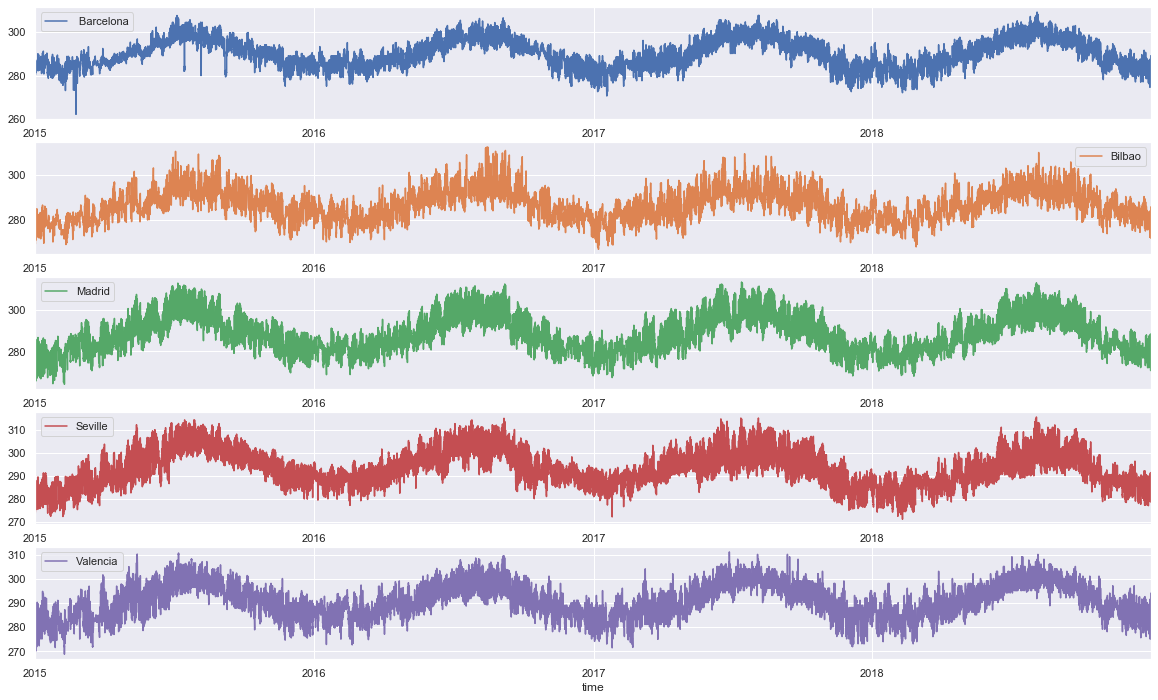

In [29]:
# Plot the hourly temperature for each city
sns.set()
fig, ax = plt.subplots(figsize=(20, 12))
temp_by_city.plot(ax=ax, subplots=True)
plt.show()

dt_iso                  0
time                    0
city_name               0
temp                    0
temp_min                0
temp_max                0
pressure               89
humidity                0
wind_speed             31
wind_deg                0
rain_1h                 0
rain_3h                 0
snow_3h                21
clouds_all              0
weather_id              0
weather_main            0
weather_description     0
weather_icon            0
year                    0
month                   0
day                     0
hour                    0
dtype: int64


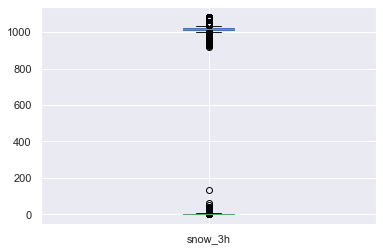

In [30]:
#Max min air pressurre recorded till now-- filtering based on the same

weather_data.loc[weather_data.pressure > 1084, 'pressure'] = np.nan
weather_data.loc[weather_data.pressure < 870, 'pressure'] = np.nan
weather_data.pressure.plot.box()
#Average day wind speed is around 7.9mph - around 4 m/s
#We are considering upto 20 m/s 
weather_data.wind_speed.plot.box()
weather_data.loc[weather_data.wind_speed > 20, 'wind_speed'].count()
weather_data.loc[weather_data.wind_speed > 20, 'wind_speed'] = np.nan

weather_data.rain_1h.plot.box()
weather_data.rain_3h.plot.box()
weather_data.snow_3h.plot.box()


#Anlaysed the values from dataset
#These are outliers- variation in the values between hourss preciding and following
weather_data.loc[weather_data.snow_3h > 10, 'snow_3h'].count()
weather_data.loc[weather_data.snow_3h > 10, 'snow_3h'] = np.nan
#Validate the missing values and interpolate

weather_data.columns[weather_data.isna().any()].tolist()
weather_data.isna().sum().sum() #overall missing values in all columns
print(weather_data.isna().sum()) 


In [31]:
#Linear interpolation to replace these outlier values
weather_data = weather_data.set_index(['dt_iso'])

for i in weather_data.columns[weather_data.isna().any()].tolist():
   weather_data[i].interpolate(method='linear', inplace=True)
#Missing values replaced   
weather_data.reset_index(level=0, inplace=True)

#Data cleaning is completed



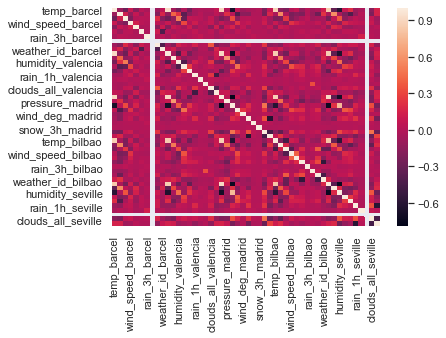

In [32]:
#understanding the impact of weather
#The pattern for all cities looks to be the same.

#weather_data.groupby('month')['temp'].mean().plot.line()
#energy_data.groupby('month')['total load forecast'].mean().plot.line()

#Comparing the weather parameters for all 5 cities, we can see that there is not
#much of a variation in the patterns for all these 5 cities
#Decide on taking a mean of all these accross the 5 cities
#These can then be merged to the energy dataset based on the time index 
#Then the improtant regressors will be identified to predict the load forecast and price forecast

weather_merge_data = weather_data.groupby('time').mean()
weather_merge_data = weather_merge_data.reset_index()
weather_merge_data.dtypes

weather_merge_data['dt_iso'] = weather_data['dt_iso']
weather_merge_data = weather_merge_data.drop(columns=['temp_min','temp_max','time','weather_id','year','month','day','hour'])

weather_merge_data = weather_merge_data.rename(columns={'dt_iso': 'time'})

energy_data_final = energy_data
data_final = energy_data_final.merge(weather_merge_data, on=['time'], how='outer')

daylight_duplicates = data_final[data_final.duplicated(subset=['time', 'generation fossil gas'])]
data_final = data_final.reset_index().drop_duplicates(subset=['time', 'generation fossil gas'], keep='first').set_index('time')


#If not considering mean and using all columns for each cities
#will it make a difference
#we can find the correlation between these factors accross each cities and see if we can have any one 
#or mean or all factors
weather_data_req = weather_data.drop(columns=['temp_min','temp_max','dt_iso','time','weather_main','weather_description','weather_icon','year','month','day','hour'])
weather_data_barcelona = weather_data_req[weather_data_req['city_name'].str.strip() == 'Barcelona']
weather_data_valencia = weather_data_req[weather_data_req['city_name'].str.strip() == 'Valencia']
weather_data_madrid = weather_data_req[weather_data_req['city_name'].str.strip() == 'Madrid']
weather_data_bilbao = weather_data_req[weather_data_req['city_name'].str.strip() == 'Bilbao']
weather_data_seville = weather_data_req[weather_data_req['city_name'].str.strip() == 'Seville']



weather_data_barcelona = weather_data_barcelona.add_suffix('_barcel')
weather_data_valencia = weather_data_valencia.add_suffix('_valencia')
weather_data_madrid = weather_data_madrid.add_suffix('_madrid')
weather_data_bilbao = weather_data_bilbao.add_suffix('_bilbao')
weather_data_seville = weather_data_seville.add_suffix('_seville')

weather_data_barcelona = weather_data_barcelona.drop(columns=['city_name_barcel'])
weather_data_valencia = weather_data_valencia.drop(columns=['city_name_valencia'])
weather_data_madrid = weather_data_madrid.drop(columns=['city_name_madrid'])
weather_data_bilbao = weather_data_bilbao.drop(columns=['city_name_bilbao'])
weather_data_seville = weather_data_seville.drop(columns=['city_name_seville'])
#combine all into a single dataframe
#check for coorelation

weather_data_combine = pd.concat([weather_data_barcelona.reset_index(drop=True), weather_data_valencia.reset_index(drop=True),
                                  weather_data_madrid.reset_index(drop=True),weather_data_bilbao.reset_index(drop=True),weather_data_seville.reset_index(drop=True)], axis=1)

corr_matrix = weather_data_combine.corr()

sns.heatmap(weather_data_combine.corr())
weather_data_combine['time'] = weather_data['dt_iso']


#Temp is having high coorelation and some weather coponenets for some cities are
#highly coorelated.
#some cities do have no values 0 in them and these can be dropped off

#Snow in barcelona empty and snow in seville - to be removed
#All temeperatures highly coorelated
#Humidity madrid and seville
#0.5 over pressure and humidity - maybe can remove if model performance is not improving


In [33]:
energy_data_final = energy_data
final_cleaned_data = energy_data_final.merge(weather_data_combine, on=['time'], how='outer')

daylight_duplicates = final_cleaned_data[final_cleaned_data.duplicated(subset=['time', 'generation fossil gas'])]
final_cleaned_data = final_cleaned_data.reset_index().drop_duplicates(subset=['time', 'generation fossil gas'], keep='first').set_index('time')
final_cleaned_data = final_cleaned_data.drop(columns=['index'])


[]

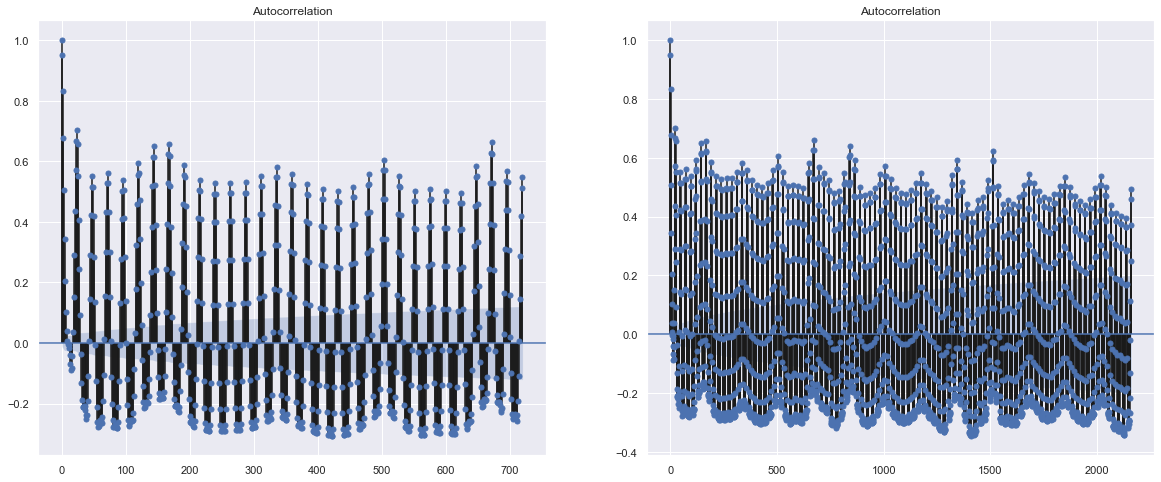

In [34]:
#isolate the original series of demand data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

energy_demand_univar = energy_data['total load actual']

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [30*24, 90*24]

for ax, lag in zip(axs.flatten(), lags):
    plot_acf(energy_demand_univar, ax=ax, lags=lag)
plt.plot()

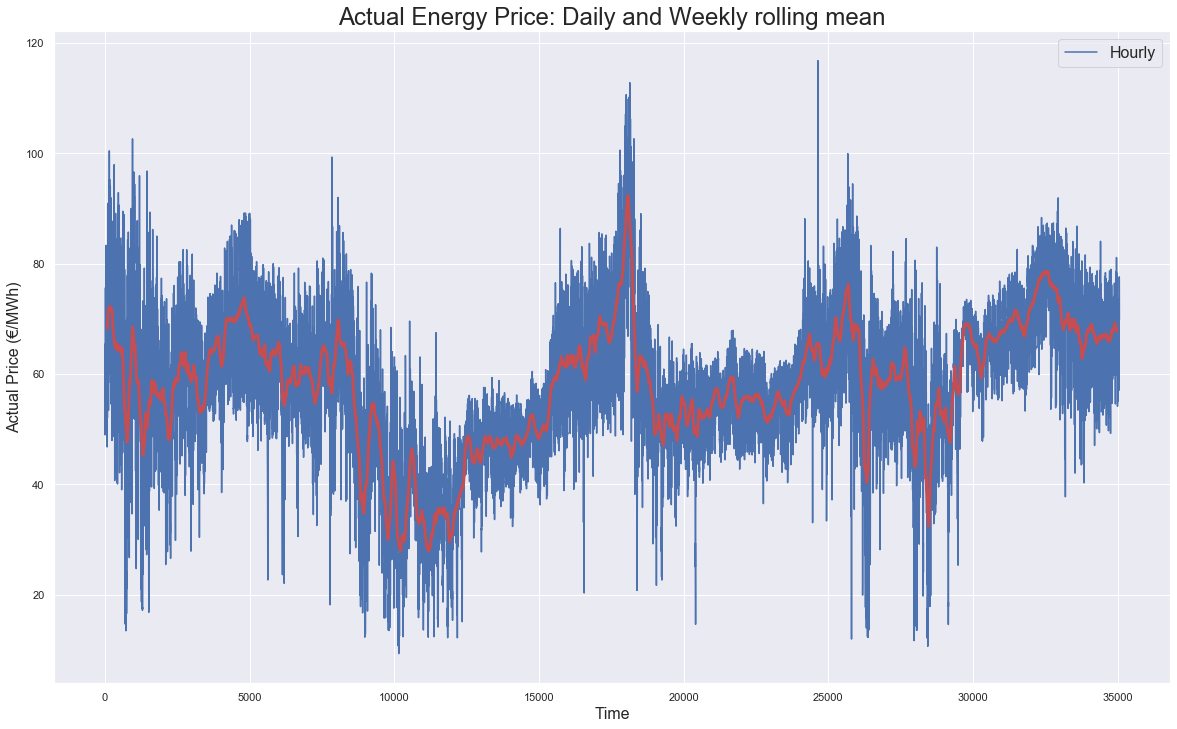

In [35]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, color='lightblue',start=0, end=None):
    
    sns.set()
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax



# Plot the hourly (actual) energy price, along with the weekly rolling mean

rolling = energy_data['price actual'].rolling(24*7, center=True).mean() #24*7 for weekly roll

ax = plot_series(energy_data, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Energy Price: Daily and Weekly rolling mean',color='lightblue')
ax.plot(rolling, linestyle='-', linewidth=3, color='r',label='Weekly rolling mean')
plt.show()


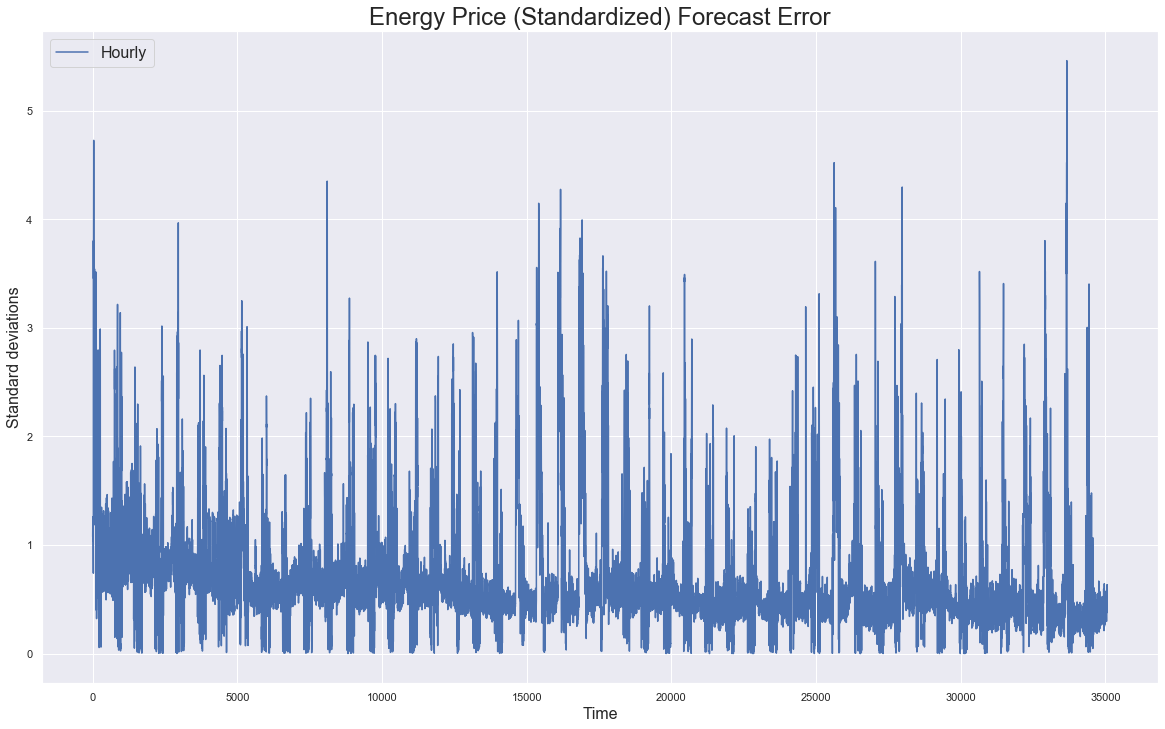

In [36]:
# Plot the standardized absolute hourly error between the actual price and the forecasted price

error_price = abs(energy_data['price actual'] - energy_data['price day ahead'])
standardized_error_price = error_price / (energy_data['price actual'].std())

ax = plot_series(series=standardized_error_price, label='Hourly', 
                 ylabel='Standard deviations', title='Energy Price (Standardized) Forecast Error')
plt.show()

In [37]:
# getting dependent and independent variables

x1 = data_final
# removing the target column revenue from x
x1 = x1.drop(['price day ahead','price actual'], axis = 1)
x1['price actual']=data_final['price actual'].shift(1)
x1.fillna(0,inplace=True)
y1 = data_final['price day ahead']

# checking the shapes
print("Shape of x1:", x1.shape)
print("Shape of y1:", y1.shape)


# splitting the data

from sklearn.model_selection import train_test_split

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 42)

# checking the shapes

print("Shape of x1_train :", x1_train.shape)
print("Shape of y1_train :", y1_train.shape)
print("Shape of x1_test :", x1_test.shape)
print("Shape of y1_test :", y1_test.shape)

Shape of x1: (35064, 34)
Shape of y1: (35064,)
Shape of x1_train : (24544, 34)
Shape of y1_train : (24544,)
Shape of x1_test : (10520, 34)
Shape of y1_test : (10520,)


[3.27866892e-02 3.84916501e-03 1.53345473e-02 4.28114858e-01
 1.30066597e-01 3.62554865e-03 2.20121295e-02 1.22850312e-02
 8.57008502e-03 1.23713172e-02 2.79358874e-03 2.87527266e-02
 2.28523383e-03 8.37635829e-03 2.35373084e-03 2.38751618e-03
 2.98499011e-03 2.62590141e-03 2.51948147e-03 2.33375576e-03
 2.94372886e-03 3.88157786e-02 3.81963038e-03 3.13912534e-04
 2.88548195e-03 3.23272114e-03 1.84839488e-03 1.48649216e-03
 1.74779075e-03 5.43603450e-04 1.60137661e-04 2.17995496e-05
 1.68814528e-03 2.14063132e-01]


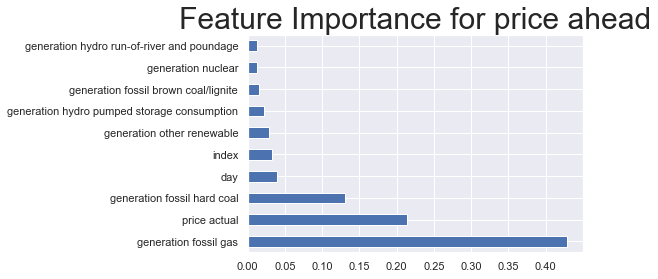

In [38]:
from sklearn.ensemble import RandomForestRegressor

random_forest_1 = RandomForestRegressor()

random_forest_1.fit(x1_train,y1_train)
print(random_forest_1.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(random_forest_1.feature_importances_, index=x1.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for price ahead', fontsize = 30)
plt.show()

Shape of x1: (35064, 74)
Shape of y1: (35064,)
Shape of x1_train : (24544, 74)
Shape of y1_train : (24544,)
Shape of x1_test : (10520, 74)
Shape of y1_test : (10520,)


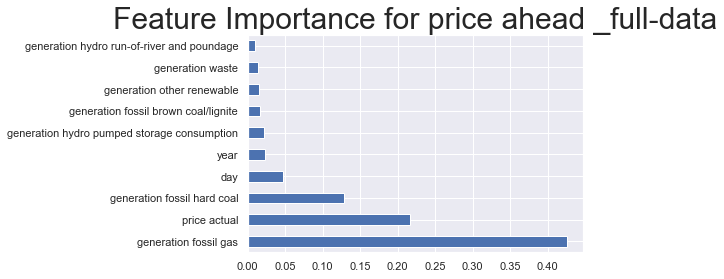

In [39]:
# getting dependent and independent variables

x1 = final_cleaned_data
# removing the target column revenue from x
x1 = x1.drop(['price day ahead','price actual'], axis = 1)
x1['price actual']=final_cleaned_data['price actual'].shift(1)
x1.fillna(0,inplace=True)
y1 = final_cleaned_data['price day ahead']

# checking the shapes
print("Shape of x1:", x1.shape)
print("Shape of y1:", y1.shape)


# splitting the data
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 42)

# checking the shapes
print("Shape of x1_train :", x1_train.shape)
print("Shape of y1_train :", y1_train.shape)
print("Shape of x1_test :", x1_test.shape)
print("Shape of y1_test :", y1_test.shape)

random_forest_2 = RandomForestRegressor()

random_forest_2.fit(x1_test,y1_test)
#print(random_forest_2.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(random_forest_2.feature_importances_, index=x1.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for price ahead _full-data', fontsize = 30)
plt.show()

Shape of x1: (35064, 51)
Shape of y1: (35064,)
Shape of x1_train : (24544, 51)
Shape of y1_train : (24544,)
Shape of x1_test : (10520, 51)
Shape of y1_test : (10520,)


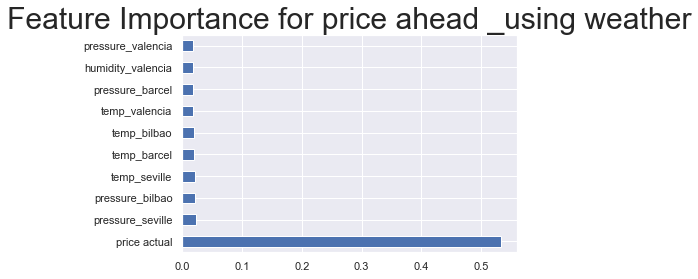

In [40]:
# getting dependent and independent variables

x1 = final_cleaned_data.iloc[:,25:]
# removing the target column revenue from x
x1['price actual']=final_cleaned_data['price actual'].shift(1)
x1.fillna(0,inplace=True)
y1 = final_cleaned_data['price day ahead']

# checking the shapes
print("Shape of x1:", x1.shape)
print("Shape of y1:", y1.shape)


# splitting the data
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 42)

# checking the shapes
print("Shape of x1_train :", x1_train.shape)
print("Shape of y1_train :", y1_train.shape)
print("Shape of x1_test :", x1_test.shape)
print("Shape of y1_test :", y1_test.shape)

random_forest_2 = RandomForestRegressor()

random_forest_2.fit(x1_test,y1_test)
#print(random_forest_2.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(random_forest_2.feature_importances_, index=x1.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for price ahead _using weather', fontsize = 30)
plt.show()

RMSE with naive approach :  14.962754967476076


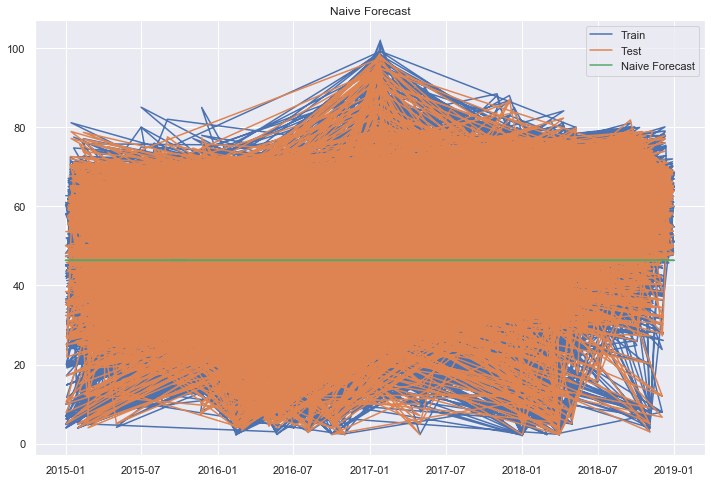

In [41]:
x2=data_final
x2_train, x2_test = train_test_split(x2, test_size = 0.3, random_state = 42)
dd= np.array(x2_train['price day ahead'])
y_hat = x2_test.copy()
k=len(dd)-1
y_hat['naive'] = dd[k]
plt.figure(figsize=(12,8))
plt.plot(x2_train.index, x2_train['price day ahead'], label='Train')
plt.plot(x2_test.index,x2_test['price day ahead'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.savefig('time-series-naive-approach.png')


rms = sqrt(mean_squared_error(x2_test['price day ahead'], y_hat.naive))
print('RMSE with naive approach : ', rms)

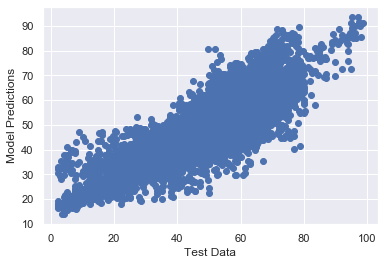

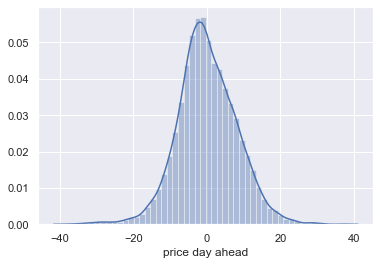

MAE: 6.22
MSE: 64.79
RMSE: 8.05
MAPE: 18.61


In [42]:
#Running Regression Model with Multiple regressors selected from feature importance 
from sklearn.linear_model import LinearRegression
data_final_3 = data_final[['generation fossil gas','price actual','price day ahead','generation fossil hard coal','day']]
x3 = data_final_3
x3 = x3.drop(['price day ahead','price actual'], axis = 1)
x3['price actual']=data_final_3['price actual'].shift(1) #using price actual with lag=1
x3.fillna(0,inplace=True)
y3 = data_final_3['price day ahead']
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.3, random_state = 42)


lm = LinearRegression()

lm.fit(x3_train,y3_train)

regression_predictions = lm.predict(x3_test)

#Scatter Plot of Predictions
plt.scatter(y3_test,regression_predictions)
plt.xlabel('Test Data')
plt.ylabel('Model Predictions')
plt.show()

#Residuals Distribution
sns.distplot((y3_test - regression_predictions),bins=50)
plt.show()

#Model Evaluation Metrics

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE:', round(metrics.mean_absolute_error(y3_test, regression_predictions),2))
print('MSE:', round(metrics.mean_squared_error(y3_test, regression_predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y3_test, regression_predictions)),2))
print('MAPE:', round(mean_absolute_percentage_error(y3_test, regression_predictions),2))




Mean Absolute Error: 3.56 degrees.


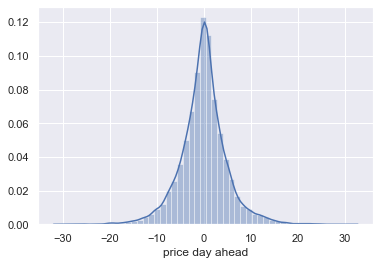

MAPE: 9.04 %.
Accuracy: 90.96 %.
MAE: 3.56
MSE: 24.75
RMSE: 4.98
MAPE: 9.04


In [43]:
random_forest_2 = RandomForestRegressor(random_state=42)

random_forest_2.fit(x3_train,y3_train)

predictions = random_forest_2.predict(x3_test)
# Calculate the absolute errors
errors = abs(predictions - y3_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

#Residuals Distribution
sns.distplot((y3_test - predictions),bins=50)
plt.show()

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y3_test)
print('MAPE:', round(mape.mean(), 2), '%.')
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


print('MAE:', round(metrics.mean_absolute_error(y3_test, predictions),2))
print('MSE:', round(metrics.mean_squared_error(y3_test, predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y3_test, predictions)),2))
print('MAPE:', round(mean_absolute_percentage_error(y3_test, predictions),2))


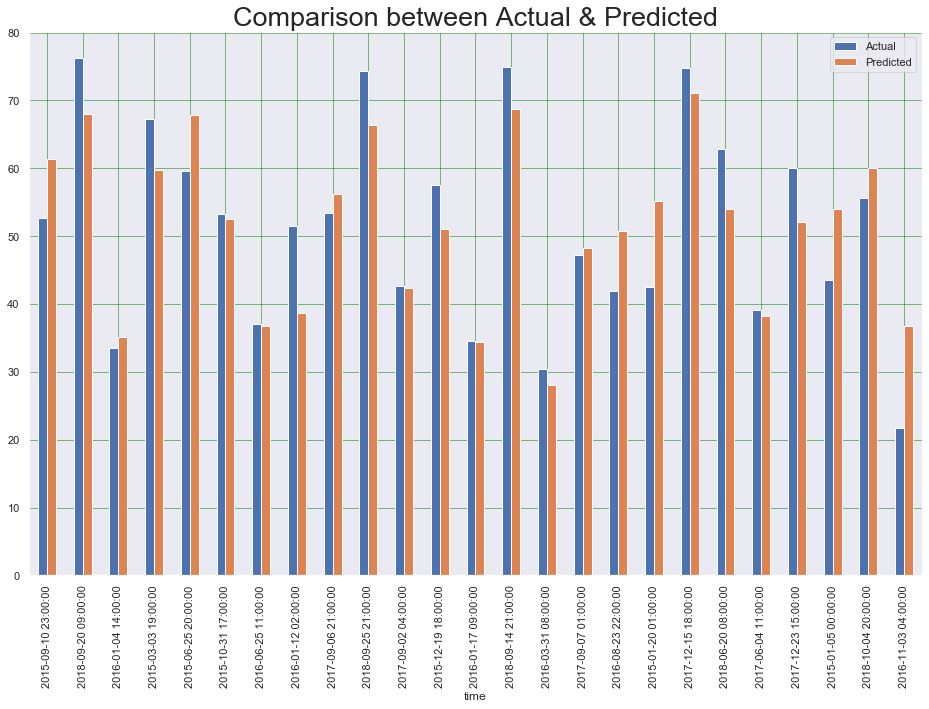

In [44]:
#Comparison between Actual and Precited for Regression model

df = pd.DataFrame({'Actual': y3_test, 'Predicted': regression_predictions})
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison between Actual & Predicted', fontsize = 27)
plt.show()

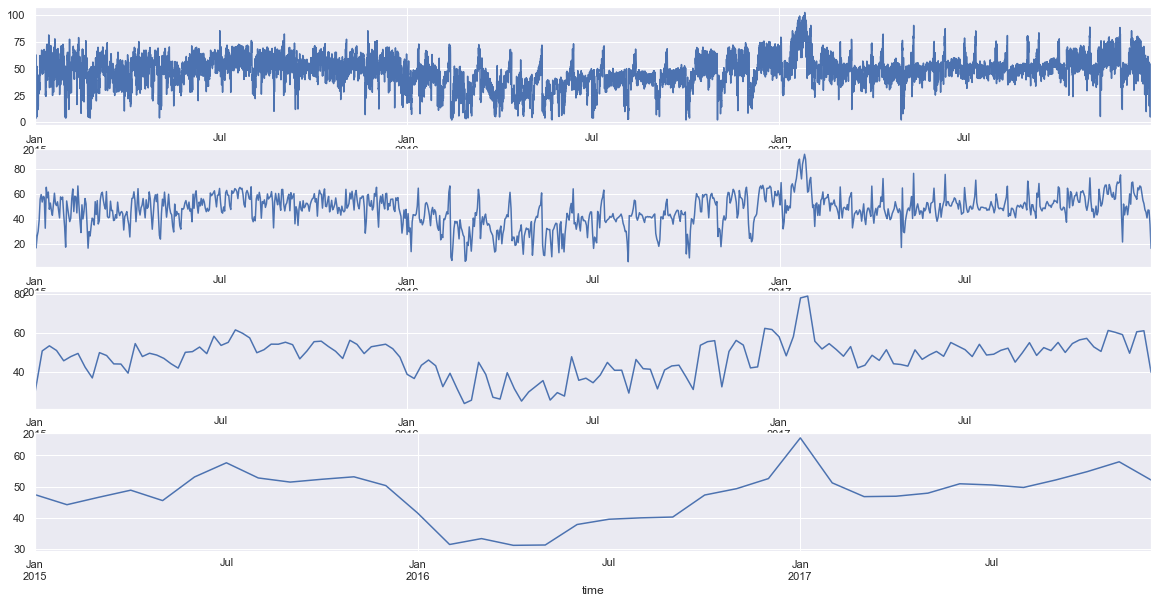

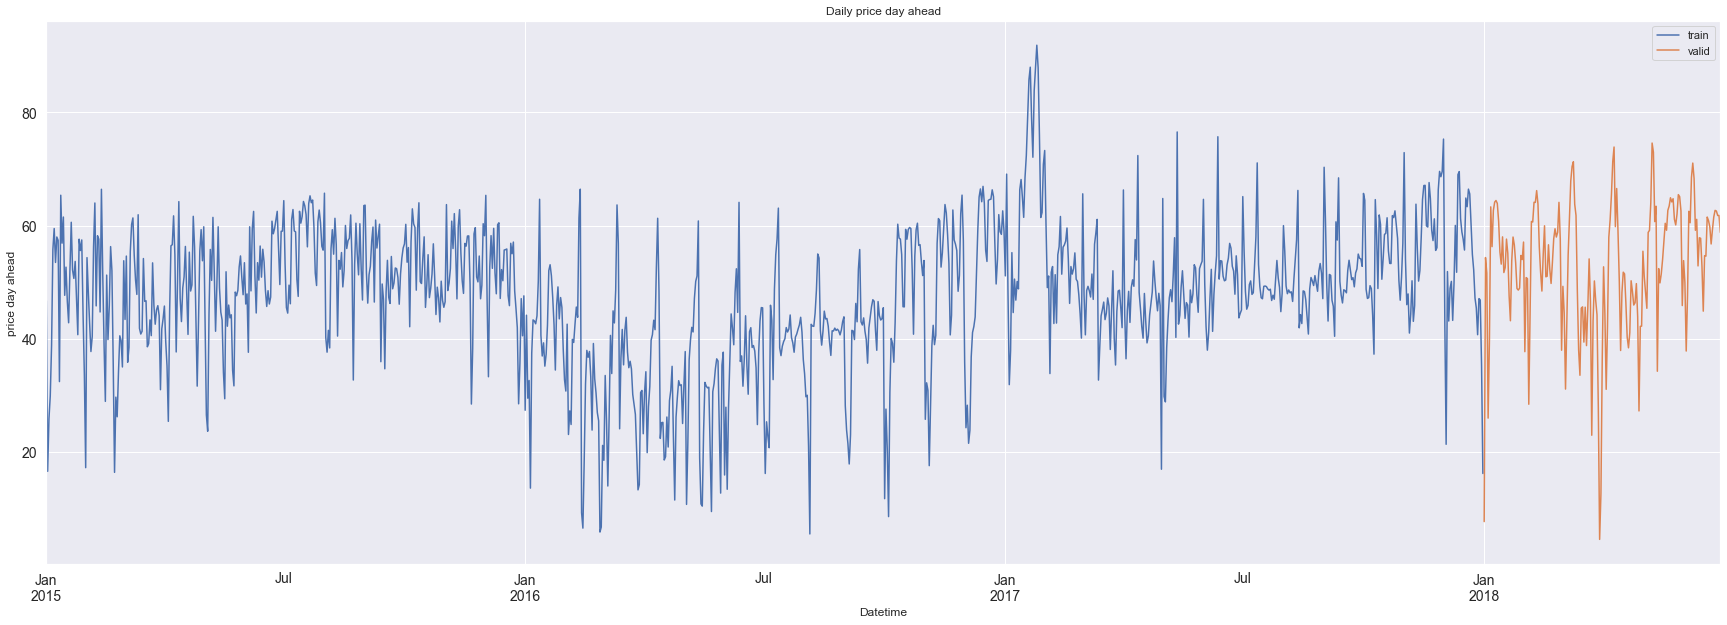

Results of Dickey-Fuller Test:
Test Statistic                -1.228865e+01
p-value                        7.919258e-23
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.556733e+00
p-value                        8.579335e-09
#Lags Used                     5.000000e+00
Number of Observations Used    1.090000e+03
Critical Value (1%)           -3.436364e+00
Critical Value (5%)           -2.864195e+00
Critical Value (10%)          -2.568184e+00
dtype: float64


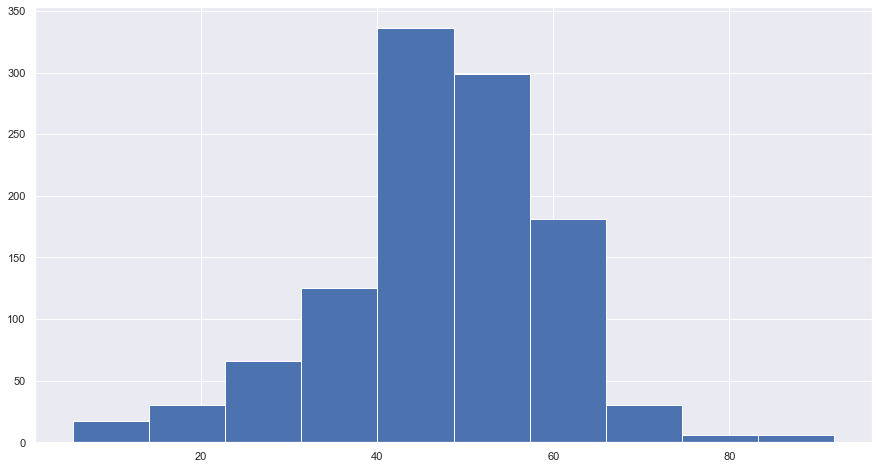

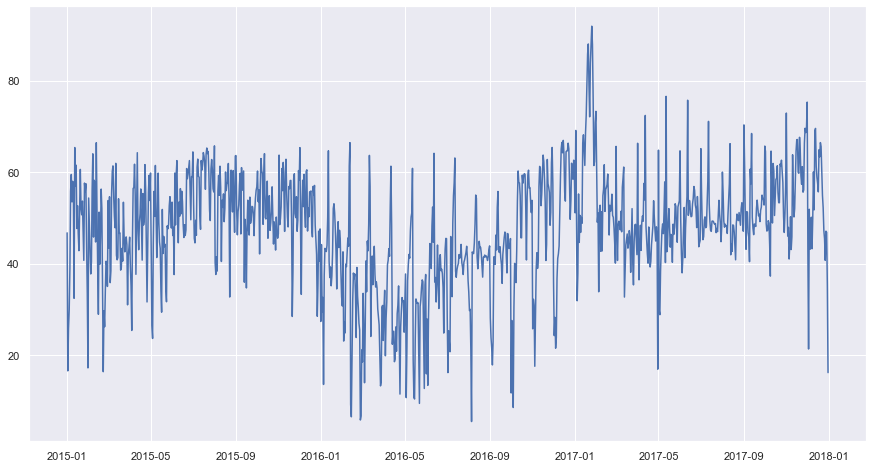

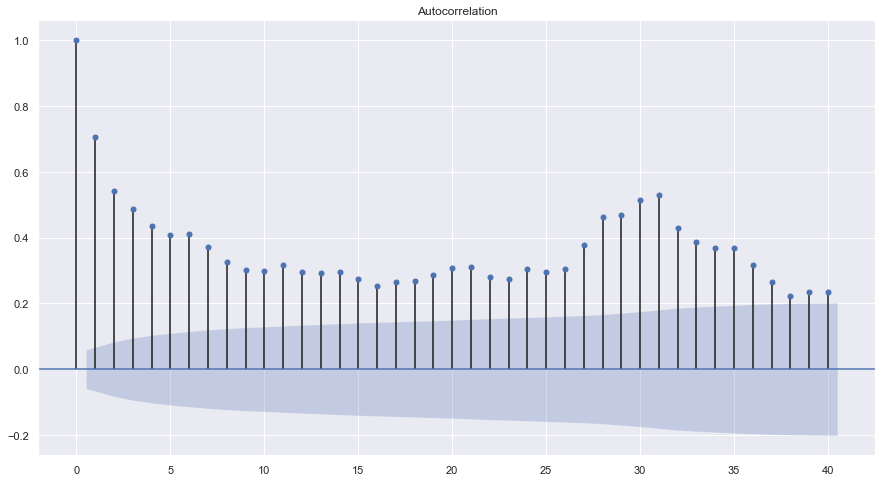

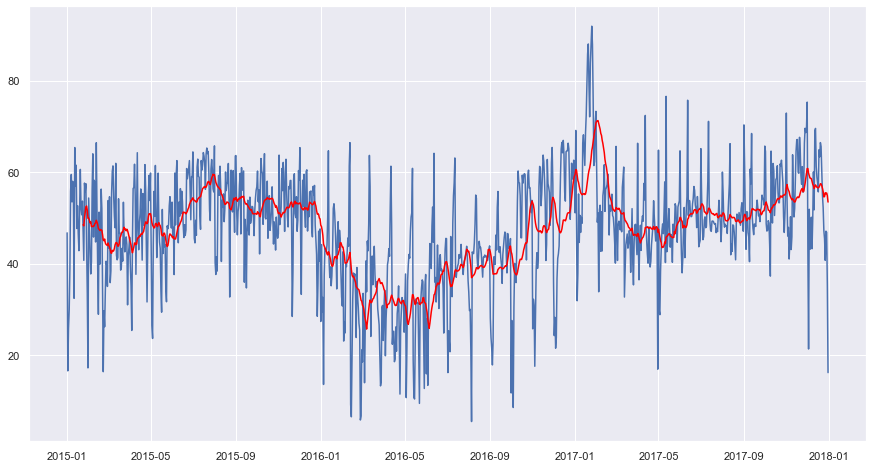

Results of Dickey-Fuller Test:
Test Statistic                -1.107686e+01
p-value                        4.410263e-20
#Lags Used                     2.200000e+01
Number of Observations Used    1.072000e+03
Critical Value (1%)           -3.436465e+00
Critical Value (5%)           -2.864240e+00
Critical Value (10%)          -2.568208e+00
dtype: float64


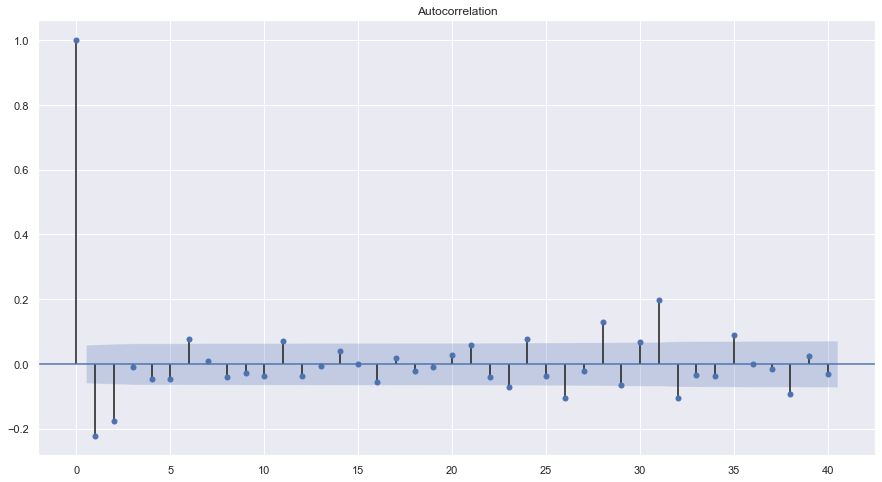

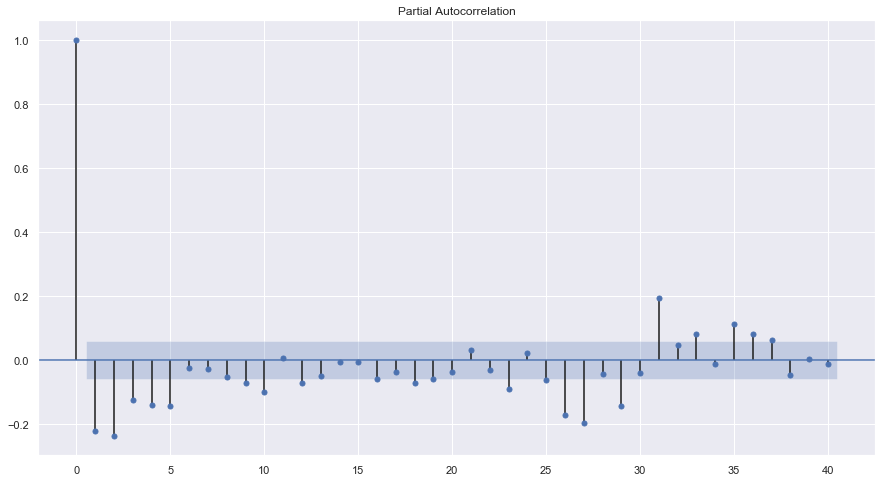

Results of Dickey-Fuller Test:
Test Statistic                -1.007559e+01
p-value                        1.226249e-17
#Lags Used                     2.200000e+01
Number of Observations Used    1.071000e+03
Critical Value (1%)           -3.436470e+00
Critical Value (5%)           -2.864242e+00
Critical Value (10%)          -2.568209e+00
dtype: float64


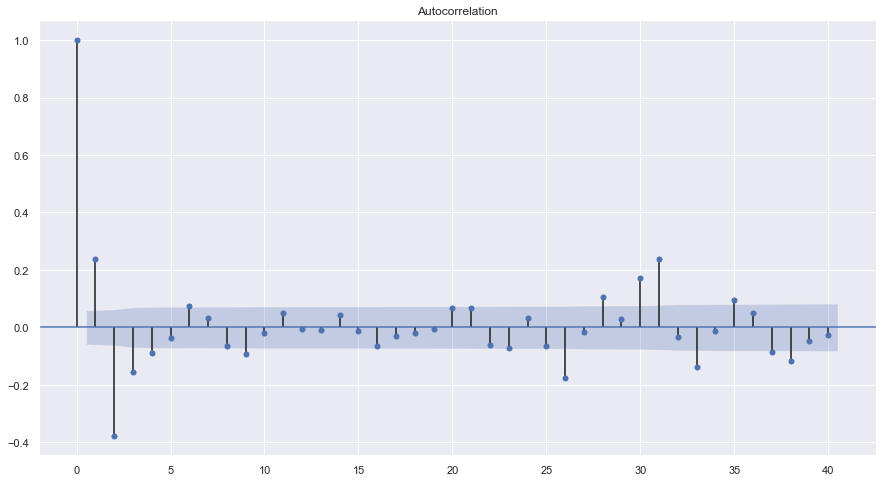

C:\Users\sanna\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead


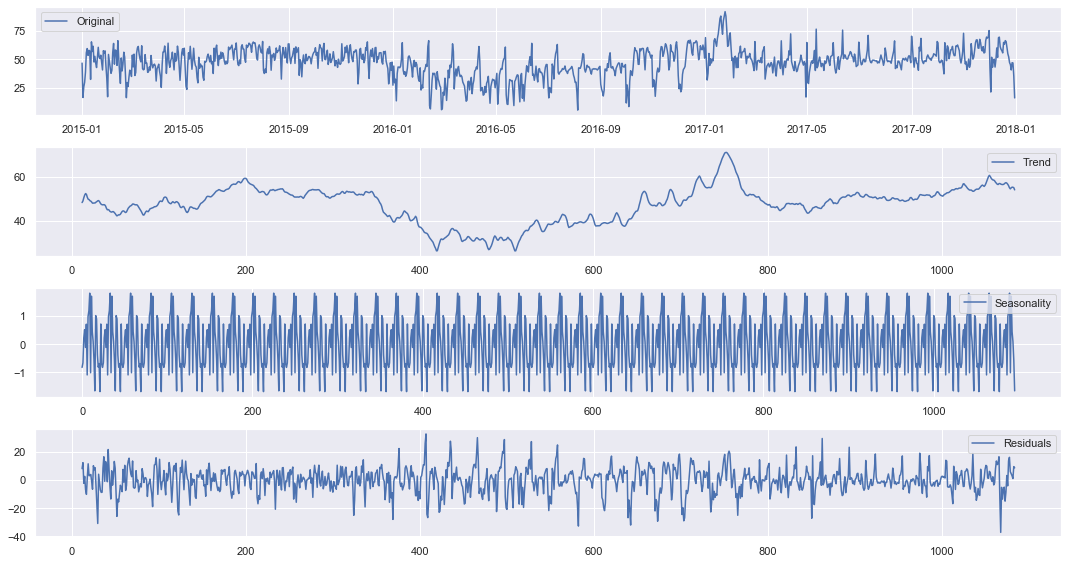

Results of Dickey-Fuller Test:
Test Statistic                -1.458195e+01
p-value                        4.453800e-27
#Lags Used                     2.200000e+01
Number of Observations Used    1.049000e+03
Critical Value (1%)           -3.436599e+00
Critical Value (5%)           -2.864299e+00
Critical Value (10%)          -2.568239e+00
dtype: float64


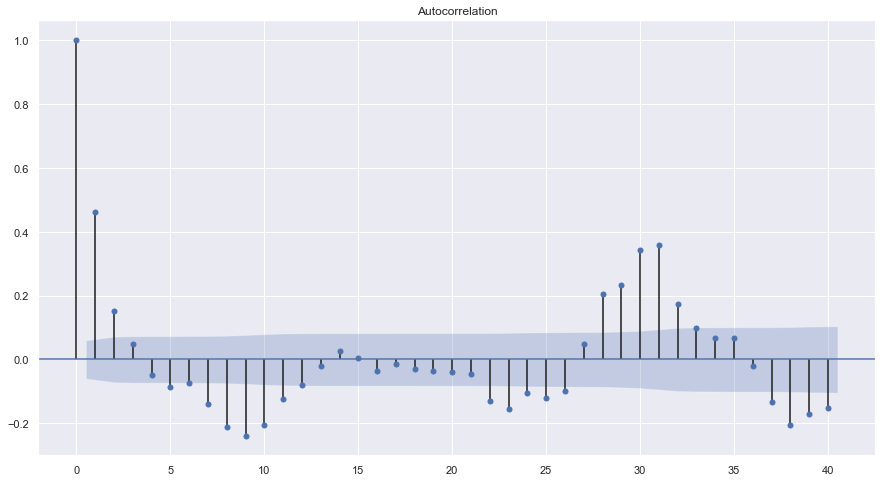

C:\Users\sanna\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


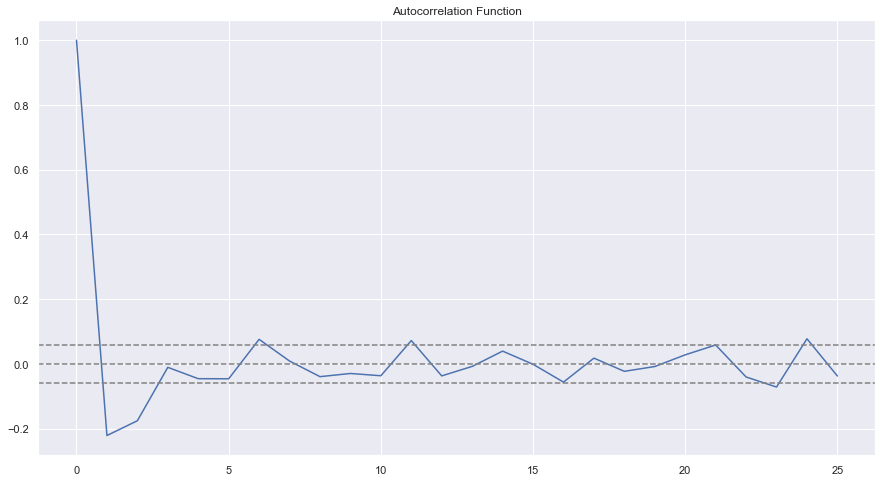

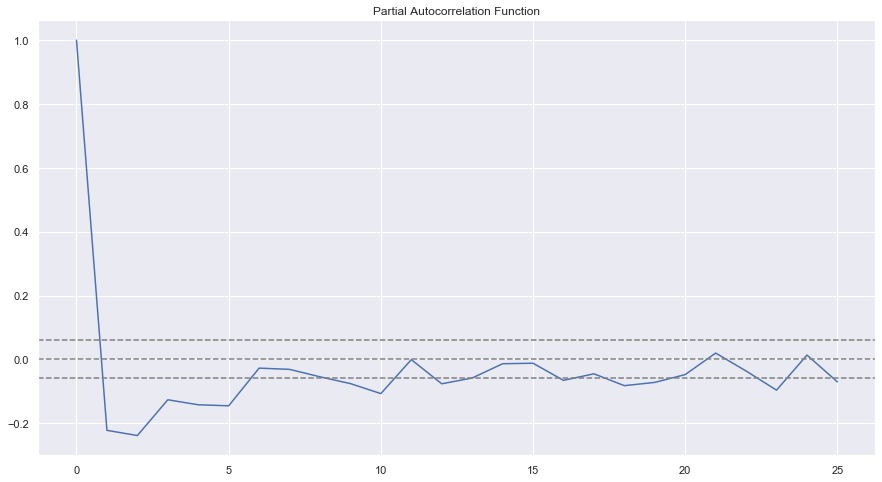

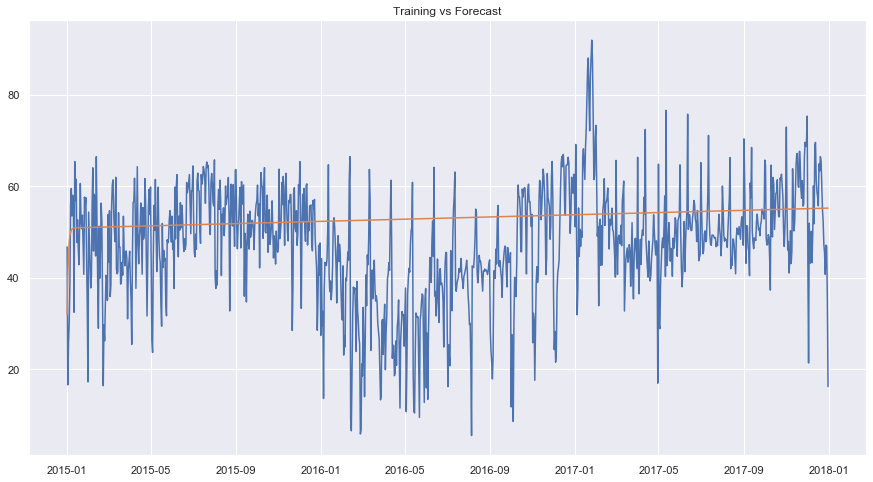

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1096
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3903.149
Date:                Mon, 27 Apr 2020   AIC                           7814.298
Time:                        00:55:24   BIC                           7834.292
Sample:                             0   HQIC                          7821.864
                               - 1096                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.012      0.155      0.877      -0.021       0.025
ar.L1          0.5470      0.022     25.235      0.000       0.504       0.589
ma.L1         -0.9576      0.010   -100.758      0.0

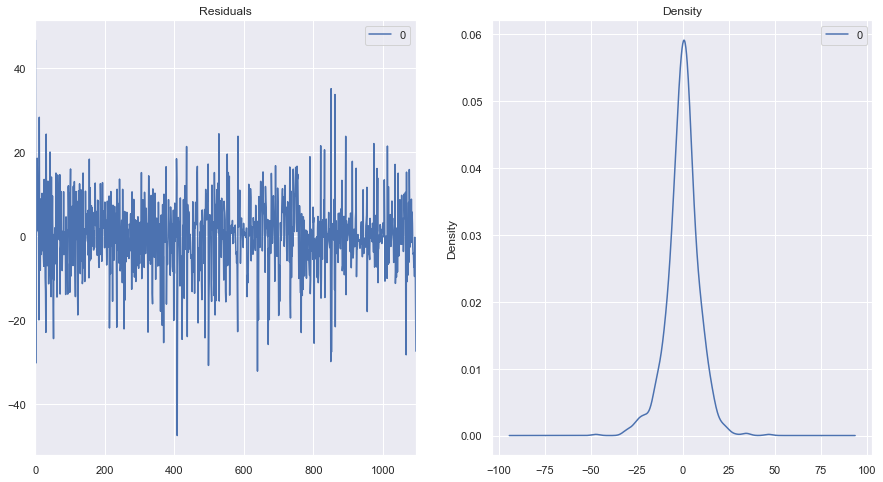

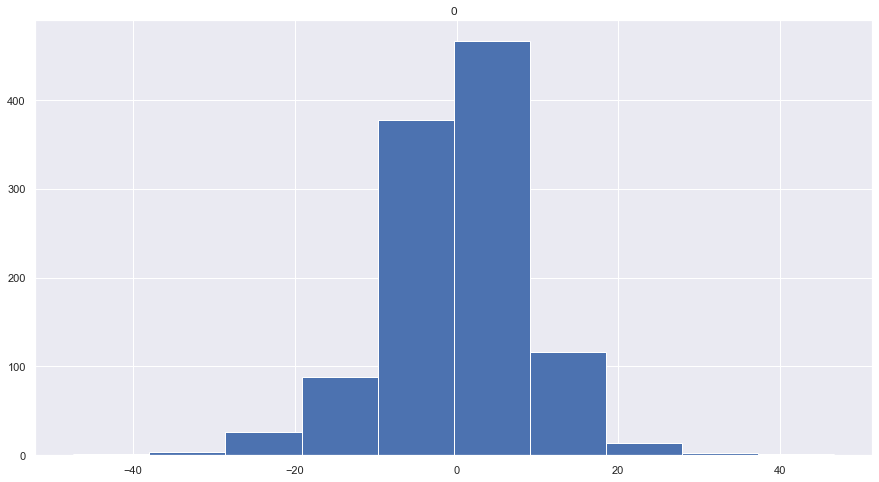

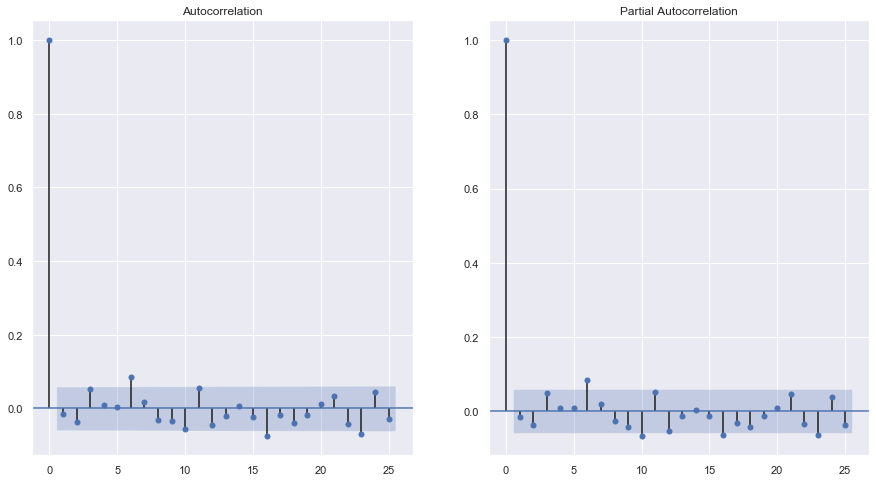

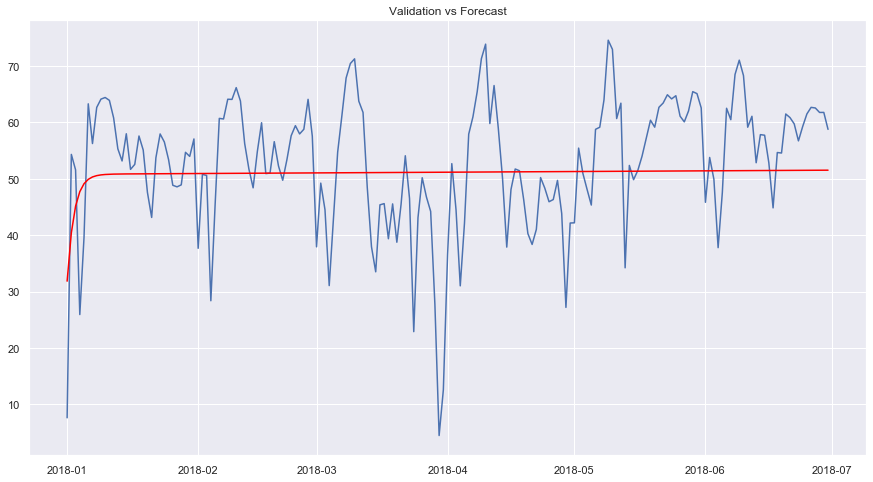

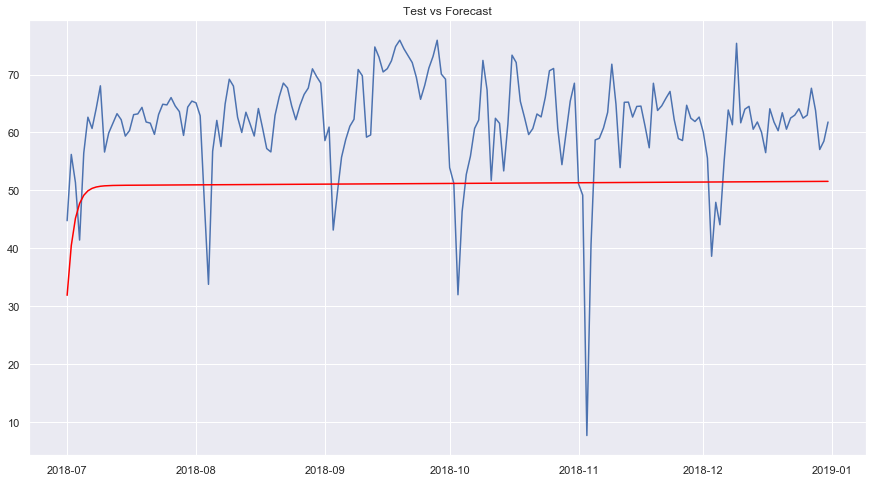

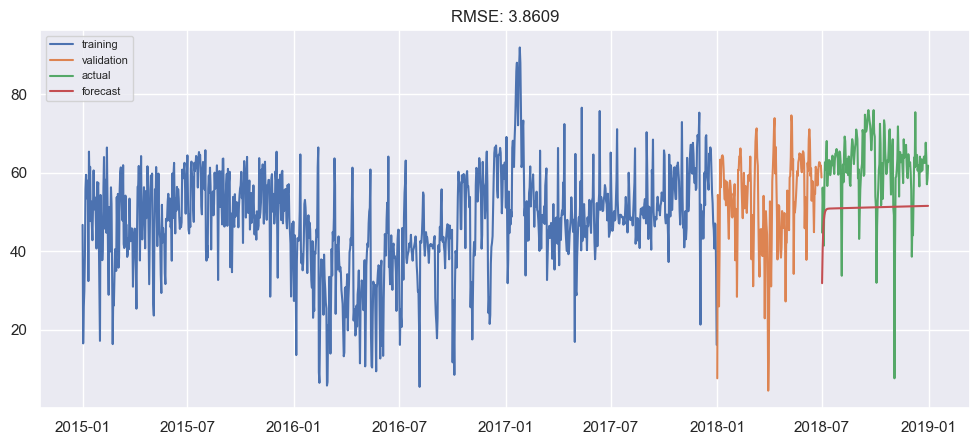

26.154390431407293
                                     SARIMAX Results                                      
Dep. Variable:                    price day ahead   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3891.568
Date:                            Mon, 27 Apr 2020   AIC                           7793.135
Time:                                    00:55:58   BIC                           7818.073
Sample:                                01-01-2015   HQIC                          7802.577
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.838e-05      0.001      0.111      0.911      -0.001       0.001
ar.L1          0

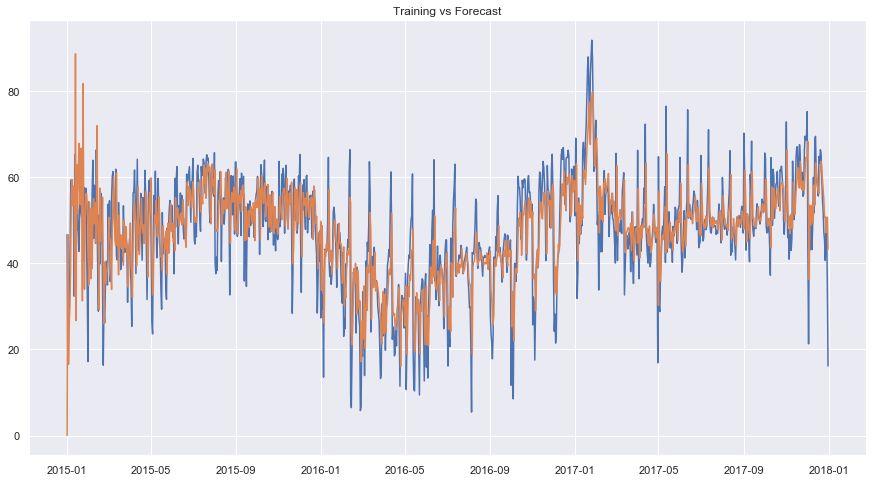

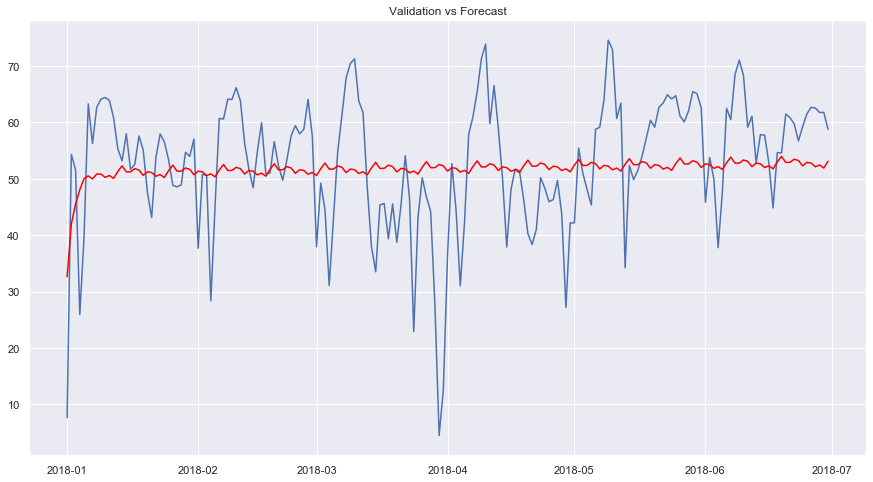

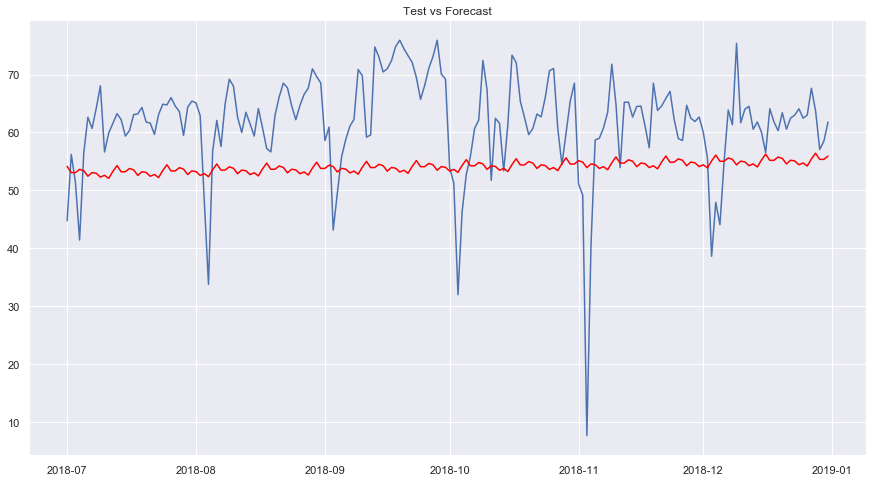

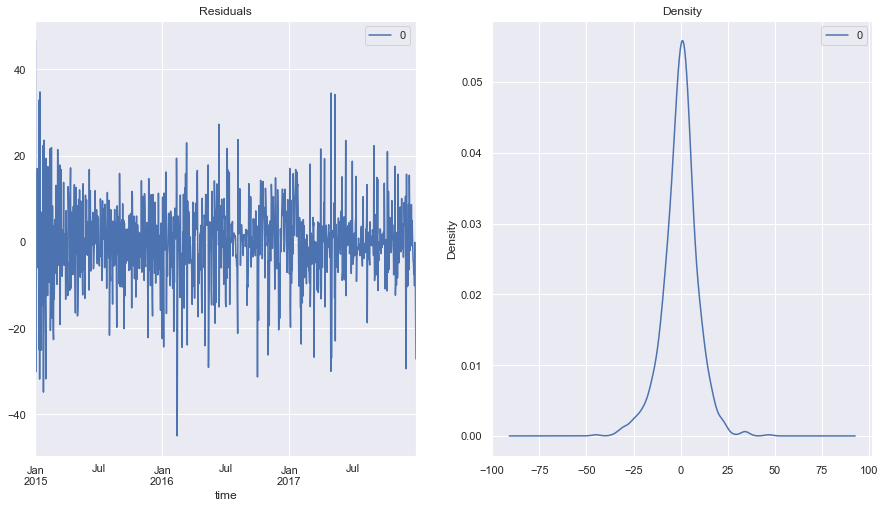

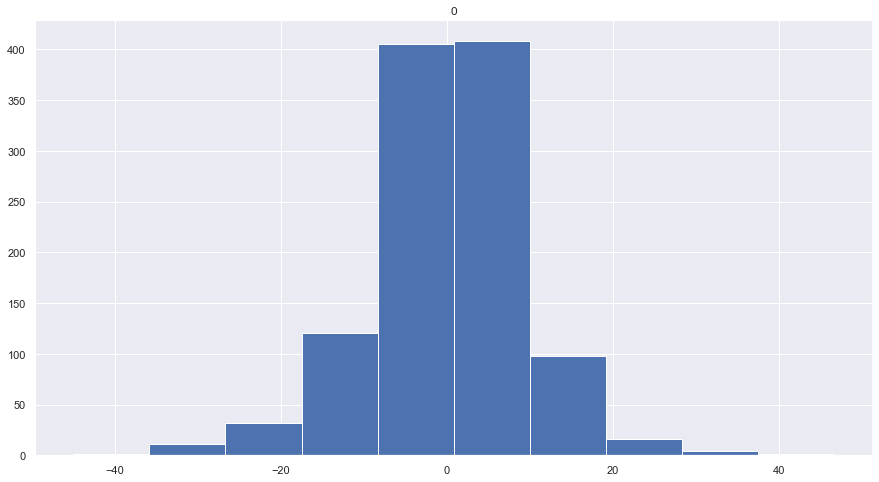

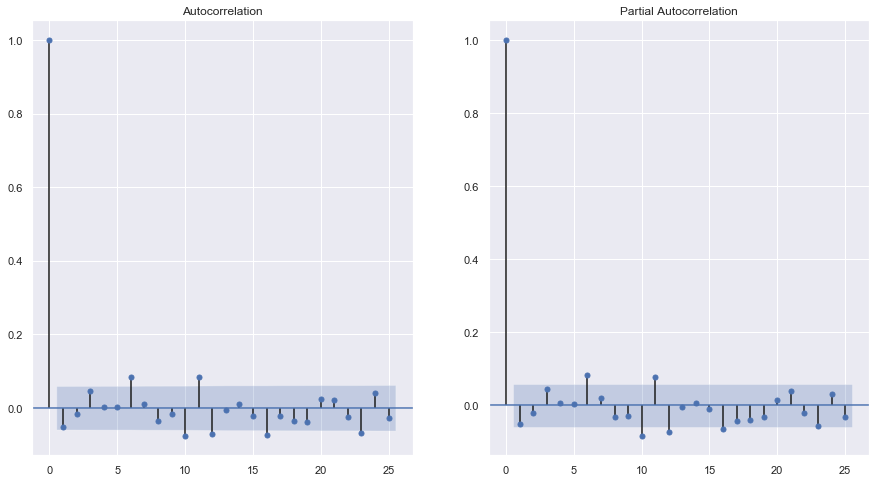

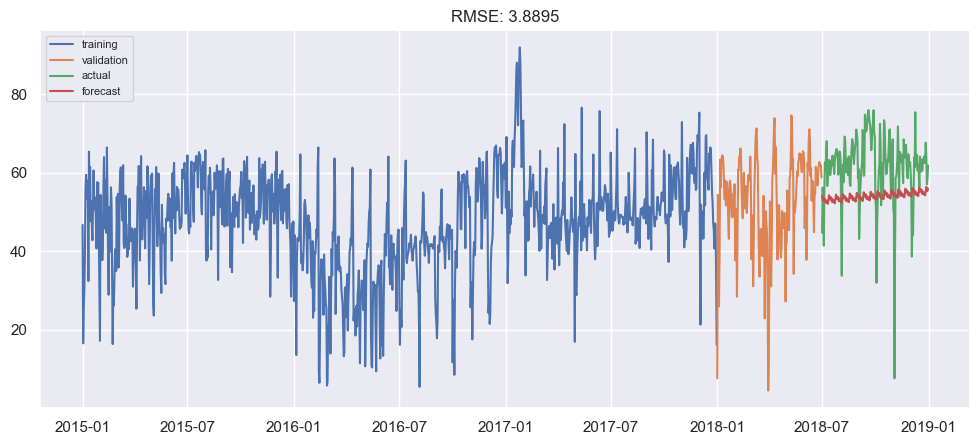

26.224102904245832


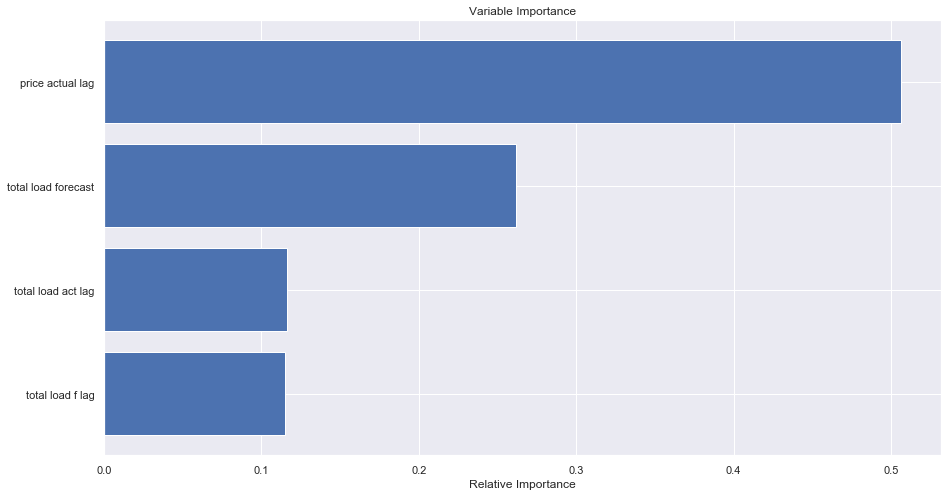

In [45]:

#Dataset split -- Training data -- validation -- test

#Training from Jan 1st 2015 - Dec 31st 2017
#Holdout sample Jan 1st 2018 - Jun 30th 2018
#Test data July 1st 2018 - Dec 31st 2018

train=final_cleaned_data.loc['2015-01-01':'2017-12-31'] 
valid=final_cleaned_data.loc['2018-01-01':'2018-06-30']
test=final_cleaned_data.loc['2018-07-01':'2018-12-31']

#Predicting the price day ahead
#Price day ahead corresponds to the price for the load forecasted based on the generation capacities available
#Price actual is the price in the live market based on the load generated to adjust for demand expected at that point
#For forecasting price day ahead, we can use the previous day price actual as a regressor along with previous price day ahead

#We will have to use the prior day actual price, actual demand, prior day ahead price and generation and weather conditions,
#along with current day forecast load and previous day forecast to predict the day ahead price for the current day.

#Taking a look at the train and validation data plot for the price day ahead


hourly_train = train.resample('H').mean()
daily_train = train.resample('D').mean()
weekly_train = train.resample('W').mean()
monthly_train = train.resample('M').mean()

hourly_train_price_foreccast = train.resample('H')['price day ahead'].mean()
daily_train_price_foreccast  = train.resample('D')['price day ahead'].mean()
weekly_train_price_foreccast  = train.resample('W')['price day ahead'].mean()
monthly_train_price_foreccast  = train.resample('M')['price day ahead'].mean()

fig,axs = plt.subplots(4,1)

hourly_train_price_foreccast.plot(kind="line", figsize=(20,10) , ax= axs[0])
daily_train_price_foreccast.plot(kind="line", figsize=(20,10) , ax= axs[1])
weekly_train_price_foreccast.plot(kind="line", figsize=(20,10),ax=axs[2])
monthly_train_price_foreccast.plot(kind="line", figsize=(20,10) , ax= axs[3])

plt.show()

#Time series is more stable when aggregating on daily, weekly and monthly compared to hourly.
#Can use the daily resample series and then downsample it for forecasting which will give better predictions.

#Resampling the validation and test samples as well to daily mean
daily_valid =  valid.resample('D').mean()
daily_test = test.resample('D').mean()


hourly_test = test.resample('H').mean()


daily_valid_price_foreccast  = daily_valid['price day ahead']
daily_test_price_foreccast  = daily_test['price day ahead']

#Check division of train v=and validation
daily_train_price_foreccast.plot(kind="line",figsize=(30,10), title= 'Daily price day ahead', fontsize=14, label='train') 
daily_valid_price_foreccast.plot(kind="line",figsize=(30,10), title= 'Daily price day ahead', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("price day ahead")
plt.legend(loc='best') 
plt.show()

#the predictions will be done for the validation part
#Based on the results will use the model to predict the test sample as well.

## ARIMA model

#Stationarity check

#from the time series plot we can clearly see that the series is not stationary
#There is no trend that can be seen
#but there is regular ups and downs indicating seasonality

#Dickey fuller test
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
#Null hypothesis - Time series is not stationary


def test_stationarity(timeseries):
     
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,8

#testing stationarity
test_stationarity(final_cleaned_data['price day ahead'])

#Test statistic shows that the series is stationary with a very low p-value
#Validating for the daily level

test_stationarity(daily_train_price_foreccast)
daily_train_price_foreccast.hist()
plt.show()
plt.plot(daily_train_price_foreccast)
plt.show()
#We can see from the tests that there is some amount of stationarity in the series.
#Though the Dickey fuller test suggests that there is no stationarity
#This can be seen from the autocorrelation plot below

sm.graphics.tsa.plot_acf(daily_train_price_foreccast.values, lags=40)
plt.show()

#We can clearly see there is no trend in the series.
#confirmed from the below
#Trend units similar to the original units
moving_average = daily_train_price_foreccast.rolling(window=24).mean()
plt.plot(daily_train_price_foreccast) 
plt.plot(moving_average, color = 'red') 
plt.show()

#Differencing to remove non-stationarity

daily_train_forecast_diff = daily_train_price_foreccast - daily_train_price_foreccast.shift() 
test_stationarity(daily_train_forecast_diff.dropna())

sm.graphics.tsa.plot_acf(daily_train_forecast_diff.dropna().values, lags=40)
plt.show()


sm.graphics.tsa.plot_pacf(daily_train_forecast_diff.dropna().values, lags=40)
plt.show()
#
daily_train_forecast_diff2 = daily_train_price_foreccast - daily_train_price_foreccast.shift().shift() 
test_stationarity(daily_train_forecast_diff2.dropna())

sm.graphics.tsa.plot_acf(daily_train_forecast_diff2.dropna().values, lags=40)
plt.show()

#First difference itself gives better results.
#No need of 2nd order differencing

#Using decomposing to make series more stationary also

#Removing the seasonality using decomposition

decomposition = seasonal_decompose(pd.DataFrame(daily_train_price_foreccast)['price day ahead'].values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(daily_train_price_foreccast, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

#Check for the seasonality of the residuals
daily_train_price_foreccast_decompose = pd.DataFrame(residual) 
daily_train_price_foreccast_decompose['date'] = daily_train_price_foreccast.index 
daily_train_price_foreccast_decompose.set_index('date', inplace = True)
daily_train_price_foreccast_decompose.dropna(inplace=True) 
test_stationarity(daily_train_price_foreccast_decompose[0])

#From the test now it is clear that the series is stationary and there is no
#trend and seasonality components
#validating with the autocorrelation plots
sm.graphics.tsa.plot_acf(daily_train_price_foreccast_decompose[0].values, lags=40)
plt.show()


#From the autocorrelation plots it is clear that differencing has removed the 
#seasonality better

#Proceeding with using differencing values of first order

#ACF and PACF for ARIMA determination

#Finding the lagged version to determine ACF and PACF


lag_acf = acf(daily_train_forecast_diff.dropna(), nlags=25) 
lag_pacf = pacf(daily_train_forecast_diff.dropna(), nlags=25, method='ols')

plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_train_forecast_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(daily_train_forecast_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show() 
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(daily_train_forecast_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(daily_train_forecast_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#From the PACF and ACF plot we can clearly see that the plot crosses the upper confidence intervals
#at p = 5 and q = 6
#using pandarima to identify the best model based on AIC

model = auto_arima(daily_train['price day ahead'],max_p =5 ,max_q=6,d = 1,max_d =1, seasonal=True) 
results = model.fit(daily_train['price day ahead'])

forecast = model.predict(n_periods=len(daily_train['price day ahead']))
forecast = pd.DataFrame(forecast,index = daily_train['price day ahead'].index,columns=['Prediction'])

#plot the predictions for training set to see the difference
plt.plot(daily_train['price day ahead'], label='original') 
plt.plot(forecast, label='Prediction')
plt.title('Training vs Forecast')
plt.show()

print(results.summary())

residuals = results.resid()
residuals = pd.DataFrame(residuals)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
residuals.hist()
plt.show()

fig, ax = plt.subplots(1,2)
fig = sm.graphics.tsa.plot_acf(residuals, lags=25, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=25, ax=ax[1])
plt.show()

forecastValid = model.predict(n_periods=len(daily_valid['price day ahead']))
forecastValid = pd.DataFrame(forecastValid,index = daily_valid['price day ahead'].index,columns=['Prediction'])

#plot the predictions for training set to see the difference
plt.plot(daily_valid['price day ahead'], label='original') 
plt.plot(forecastValid, label='Prediction',color='red')
plt.title('Validation vs Forecast')
plt.show()

forecasttest = model.predict(n_periods=len(daily_test['price day ahead']))
forecasttest = pd.DataFrame(forecasttest,index = daily_test['price day ahead'].index,columns=['Prediction'])

#plot the predictions for training set to see the difference
plt.plot(daily_test['price day ahead'], label='original') 
plt.plot(forecasttest, label='Prediction',color='red')
plt.title('Test vs Forecast')
plt.show()

#Forecast plot 

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(daily_train['price day ahead'], label='training')
plt.plot(daily_valid['price day ahead'], label='validation')
plt.plot(daily_test['price day ahead'], label='actual')
plt.plot(forecasttest, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(forecastValid['Prediction'], daily_valid['price day ahead']))/daily_valid['price day ahead'].shape[0])) 
plt.show()
print(mean_absolute_percentage_error(daily_valid['price day ahead'],forecastValid['Prediction']))

#checking the model based on pandarima auto model adding seasonal components
modelS = sm.tsa.statespace.SARIMAX(daily_train['price day ahead'],trend='c', order=(1,1,1),seasonal_order=(0,1,1,12) , freq='D')
# fit model
modelS_fit = modelS.fit(disp=-1)
print(modelS_fit.summary())

forecastS = modelS_fit.predict(n_periods=len(daily_train['price day ahead']))
forecastS = pd.DataFrame(forecastS,index = daily_train['price day ahead'].index,columns=['Prediction'])

#plot the predictions for training set to see the difference
plt.plot(daily_train['price day ahead'], label='original') 
plt.plot(forecastS, label='Prediction')
plt.title('Training vs Forecast')
plt.show()

forecastFutureS = modelS_fit.forecast(365,alpha=0.05)
forecastValidS = pd.DataFrame(forecastFutureS,index = daily_valid['price day ahead'].index,columns=['Prediction'])
forecastTestS =  pd.DataFrame(forecastFutureS,index = daily_test['price day ahead'].index,columns=['Prediction'])
#plot the predictions for validation set to see the difference
plt.plot(daily_valid['price day ahead'], label='original') 
plt.plot(forecastValidS, label='Prediction',color='red')
plt.title('Validation vs Forecast')
plt.show()
#plot the predictions for test set to see the difference
plt.plot(daily_test['price day ahead'], label='original') 
plt.plot(forecastTestS, label='Prediction',color='red')
plt.title('Test vs Forecast')
plt.show()

#Residuals check
residualsS = modelS_fit.resid
residualsS = pd.DataFrame(modelS_fit.resid)
fig, ax = plt.subplots(1,2)
residualsS.plot(title="Residuals", ax=ax[0])
residualsS.plot(kind='kde', title='Density', ax=ax[1])
residualsS.hist()
plt.show()
fig, ax = plt.subplots(1,2)
fig = sm.graphics.tsa.plot_acf(residualsS, lags=25, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residualsS, lags=25, ax=ax[1])
plt.show()

#sm.stats.acorr_ljungbox(modelS_fit.resid, lags=[5], return_df=True)

####
# Forecast
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(daily_train['price day ahead'], label='training')
plt.plot(daily_valid['price day ahead'], label='validation')
plt.plot(daily_test['price day ahead'], label='actual')
plt.plot(forecastTestS, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(forecastValidS['Prediction'], daily_valid['price day ahead']))/daily_valid['price day ahead'].shape[0])) 
plt.show()
print(mean_absolute_percentage_error(daily_valid['price day ahead'],forecastValidS['Prediction']))
#####


#Against the price day ahead
#Add lagged values for 'price actual' , 'total load actual', 'total load forecast'

#Training
daily_train['price actual lag'] = daily_train['price actual'].shift()
daily_train['total load act lag'] = daily_train['total load actual'].shift()
daily_train['total load f lag'] = daily_train['total load forecast'].shift()

daily_train['price actual lag'][0] = daily_train['price actual'][0]
daily_train['total load act lag'][0] = daily_train['total load actual'][0]
daily_train['total load f lag'][0] = daily_train['total load forecast'][0]

daily_train['price actual lag'].reindex(daily_train['price day ahead'].index)
daily_train['total load act lag'].reindex(daily_train['price day ahead'].index)
daily_train['total load f lag'].reindex(daily_train['price day ahead'].index)

#Validation

daily_valid['price actual lag'] = daily_valid['price actual'].shift()
daily_valid['total load act lag'] = daily_valid['total load actual'].shift()
daily_valid['total load f lag'] = daily_valid['total load forecast'].shift()

daily_valid['price actual lag'][0] = daily_valid['price actual'][0]
daily_valid['total load act lag'][0] = daily_valid['total load actual'][0]
daily_valid['total load f lag'][0] = daily_valid['total load forecast'][0]

daily_valid['price actual lag'].reindex(daily_valid['price day ahead'].index)
daily_valid['total load act lag'].reindex(daily_valid['price day ahead'].index)
daily_valid['total load f lag'].reindex(daily_valid['price day ahead'].index)

#Test

daily_test['price actual lag'] = daily_test['price actual'].shift()
daily_test['total load act lag'] = daily_test['total load actual'].shift()
daily_test['total load f lag'] = daily_test['total load forecast'].shift()

daily_test['price actual lag'][0] = daily_test['price actual'][0]
daily_test['total load act lag'][0] = daily_test['total load actual'][0]
daily_test['total load f lag'][0] = daily_test['total load forecast'][0]

daily_test['price actual lag'].reindex(daily_test['price day ahead'].index)
daily_test['total load act lag'].reindex(daily_test['price day ahead'].index)
daily_test['total load f lag'].reindex(daily_test['price day ahead'].index)

#Adding exogenous variables
#checking correlation of the below variables
#Checking for feature importance
from sklearn.ensemble import RandomForestRegressor 

regressors = np.array(['price actual lag',
                     'total load act lag', 'total load f lag',
                     'total load forecast'])
rfc = RandomForestRegressor()
rfc.fit(daily_train[regressors], daily_train['price day ahead'])

# from the calculated importances, order them from most to least important
# and make a barplot so we can visualize what is/isn't important
importances = rfc.feature_importances_
sorted_idx = np.argsort(importances)


padding = np.arange(len(regressors)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, regressors[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()




C:\Users\sanna\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                    price day ahead   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3889.008
Date:                            Mon, 27 Apr 2020   AIC                           7790.017
Time:                                    00:56:30   BIC                           7819.942
Sample:                                01-01-2015   HQIC                          7801.346
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         2.844e-05      0.000      0.059      0.953      -0.001       0.001
price actual lag 

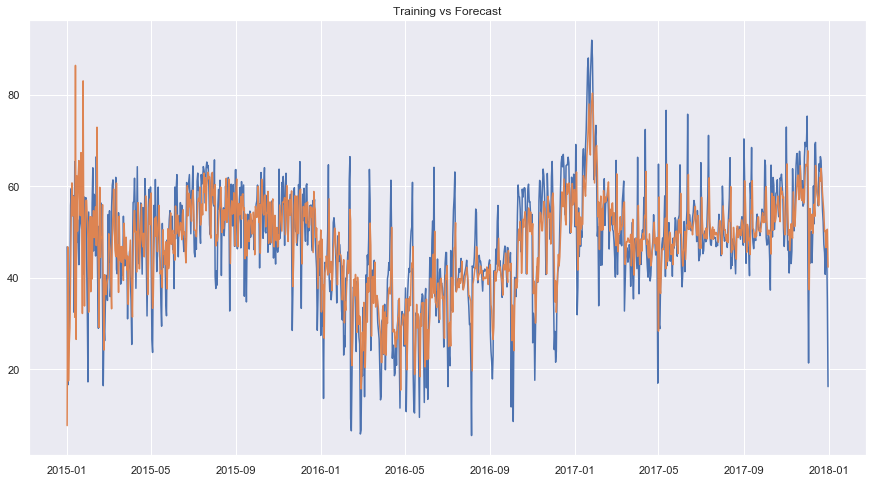

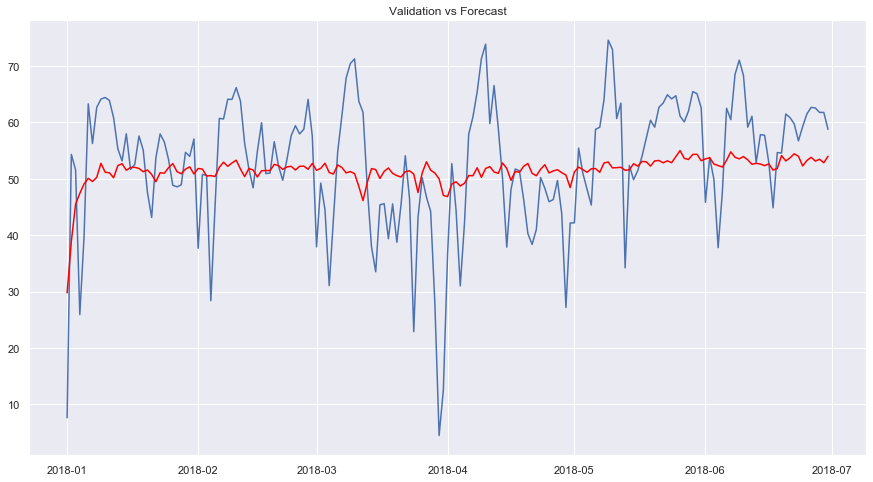

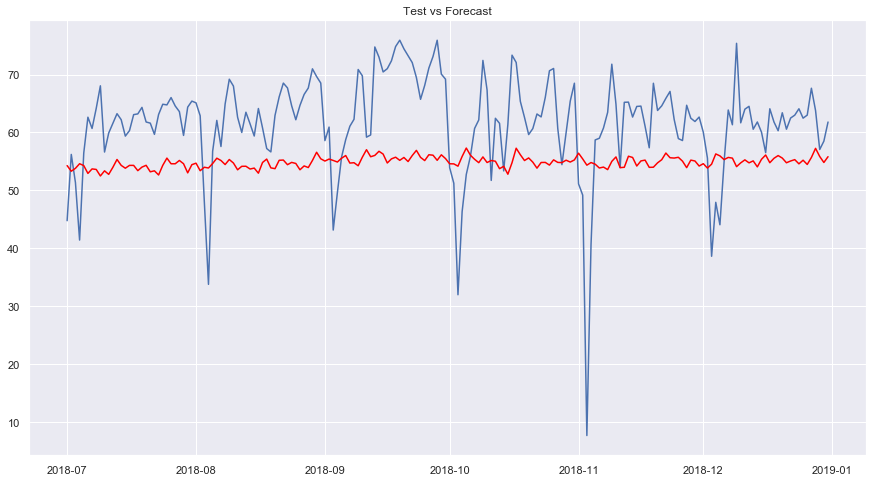

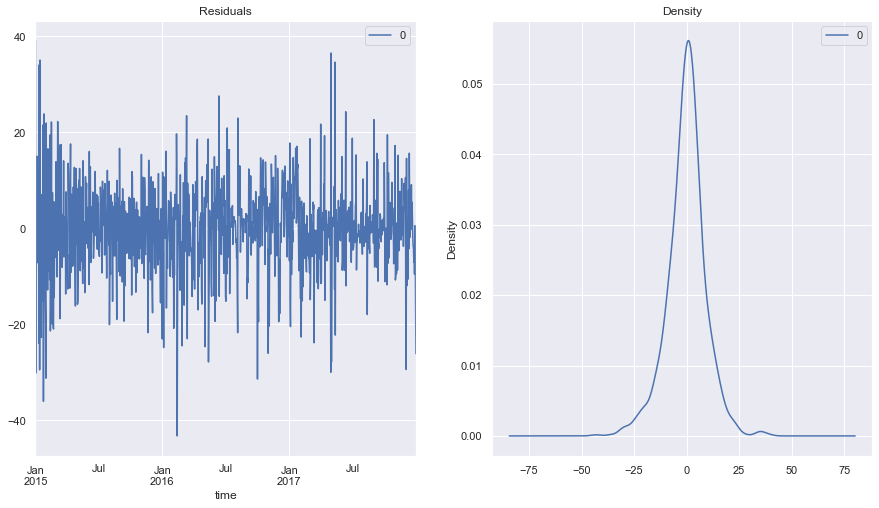

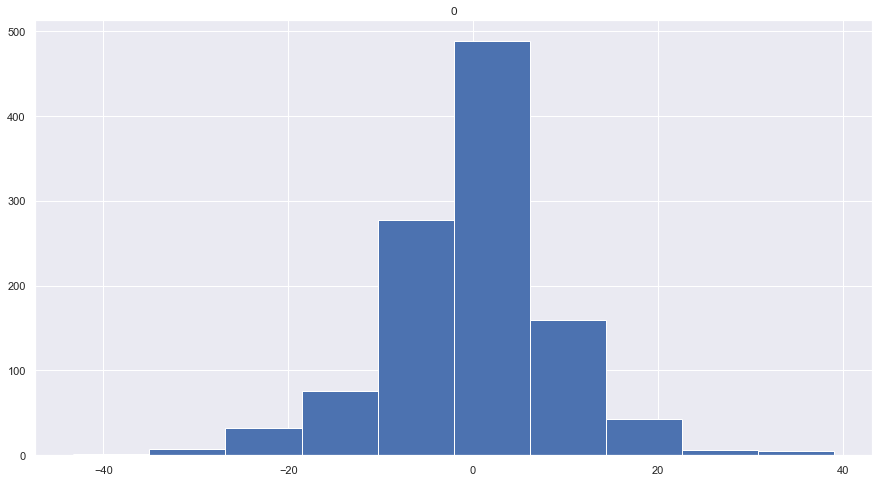

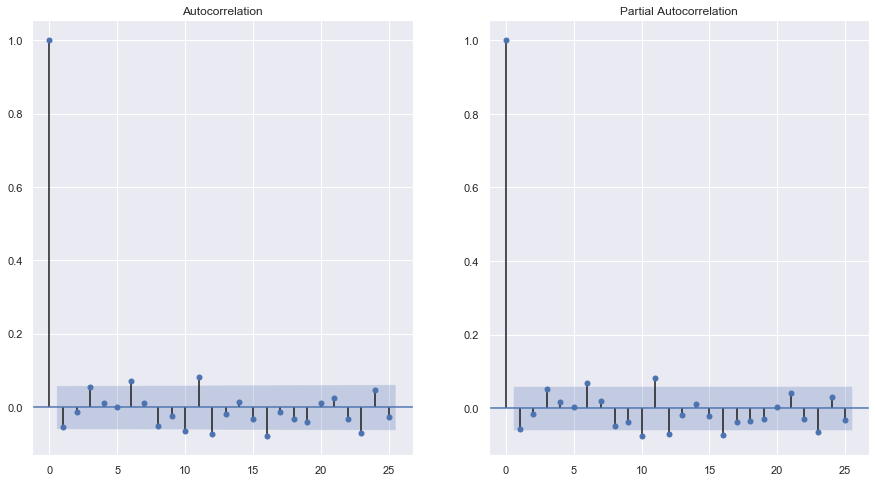

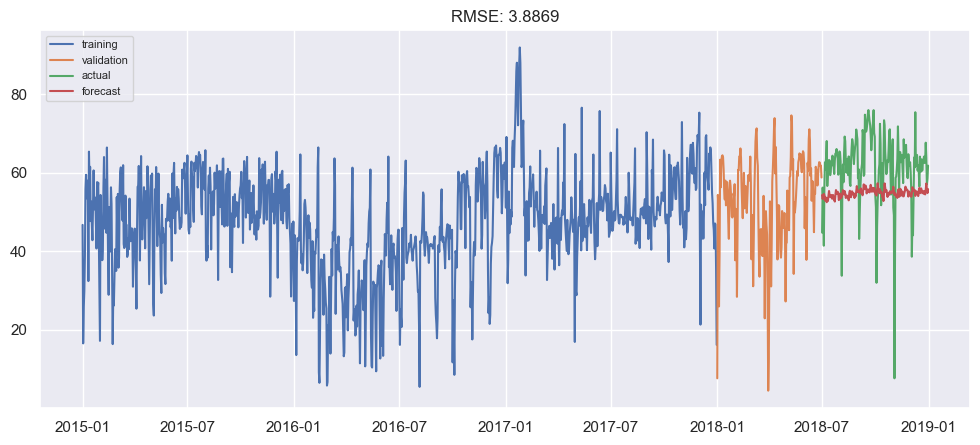

24.69809619015837


C:\Users\sanna\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
#price actual lag is of more importance
#using this regressor alone in addition to the seasonal and AR, MA components
model = sm.tsa.statespace.SARIMAX(daily_train['price day ahead'],exog=daily_train[['price actual lag']] ,trend='c', 
                                  order=(1,1,1),seasonal_order=(0,1,1,12) , freq='D')
# fit model
model_fit = model.fit(disp=-1)
print(model_fit.summary())

forecast = model_fit.predict(n_periods=len(daily_train['price day ahead']))
forecast = pd.DataFrame(forecast,index = daily_train['price day ahead'].index,columns=['Prediction'])

#plot the predictions for training set to see the difference
plt.plot(daily_train['price day ahead'], label='original') 
plt.plot(forecast, label='Prediction')
plt.title('Training vs Forecast')
plt.show()



exogValues1 = np.hstack((daily_valid['price actual lag'].values,daily_test['price actual lag'].values))
#exogValues2 = np.hstack((daily_valid['total load forecast'].values,daily_test['total load forecast'].values))

#exogValues=np.column_stack([exogValues1,exogValues2])
exogValues1 = pd.DataFrame(exogValues1)
forecastFuture = model_fit.forecast(365,alpha=0.05,exog=(exogValues1))
forecastValid = pd.DataFrame(forecastFuture,index = daily_valid['price day ahead'].index,columns=['Prediction'])
forecastTest =  pd.DataFrame(forecastFuture,index = daily_test['price day ahead'].index,columns=['Prediction'])
#plot the predictions for validation set to see the difference
plt.plot(daily_valid['price day ahead'], label='original') 
plt.plot(forecastValid, label='Prediction',color='red')
plt.title('Validation vs Forecast')
plt.show()
#plot the predictions for test set to see the difference
plt.plot(daily_test['price day ahead'], label='original') 
plt.plot(forecastTest, label='Prediction',color='red')
plt.title('Test vs Forecast')
plt.show()

#Residuals check
residuals = model_fit.resid
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
residuals.hist()
plt.show()
fig, ax = plt.subplots(1,2)
fig = sm.graphics.tsa.plot_acf(residuals, lags=25, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=25, ax=ax[1])
plt.show()

#sm.stats.acorr_ljungbox(model_fit.resid, lags=[5], return_df=True)
####
# Forecast
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(daily_train['price day ahead'], label='training')
plt.plot(daily_valid['price day ahead'], label='validation')
plt.plot(daily_test['price day ahead'], label='actual')
plt.plot(forecastTest, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(forecastValid['Prediction'], daily_valid['price day ahead']))/daily_valid['price day ahead'].shape[0])) 
plt.show()
print(mean_absolute_percentage_error(daily_valid['price day ahead'],forecastValid['Prediction']))
#####
#MAPE reduced considerably

#Merging with the hourly data

#calculating the hourly prediction test 

hourly_test['ratio']= hourly_test['price day ahead']/hourly_test['price day ahead'].sum() 
hourly_test['time'] = hourly_test.index
#Group hourly
temp=hourly_test.groupby(['hour'])['ratio'].sum()
temp = pd.DataFrame(temp)
temp['hour_y'.strip()] = np.arange(24)

daily_test['Prediction'] = forecastTest

merge=pd.merge(daily_test, hourly_test, on=('day','month', 'year'), how='left') 

merge = merge.drop(columns=['ratio'])
mergef = pd.merge(temp,merge,on=('hour_y'),how='left')

hourly_predictions = mergef[['Prediction','ratio','time']]

hourly_predictions['Predicted'] = hourly_predictions['Prediction']*hourly_predictions['ratio']*24
hourly_predictions =hourly_predictions.set_index('time')

In [47]:
x = final_cleaned_data
x = x.drop(['price day ahead','price actual'], axis = 1)
x['price actual']=final_cleaned_data['price actual'].shift(1)
x.fillna(0,inplace=True)
y = final_cleaned_data['price day ahead']


train_len = int(np.ceil(len(final_cleaned_data) * 0.75))
x_train=x[0:train_len] 
x_test=x[train_len:]
y_train = y[0:train_len] 
y_test = y[train_len:]

                            OLS Regression Results                            
Dep. Variable:        price day ahead   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     18.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-05
Time:                        00:56:43   Log-Likelihood:                -4307.4
No. Observations:                1096   AIC:                             8619.
Df Residuals:                    1094   BIC:                             8629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.5949      0.744     59.908      0.0

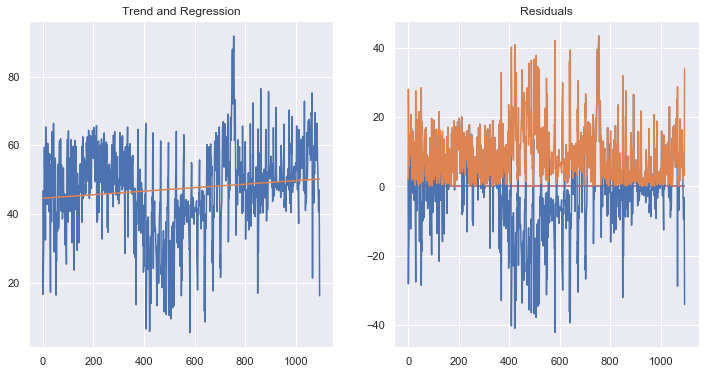

In [48]:
import statsmodels.api as sm
from statsmodels.api import OLS

x, y = np.arange(len(daily_train['price day ahead'])), daily_train['price day ahead']
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(daily_train['price day ahead'].values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(daily_train['price day ahead']))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

C:\Users\sanna\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\sanna\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


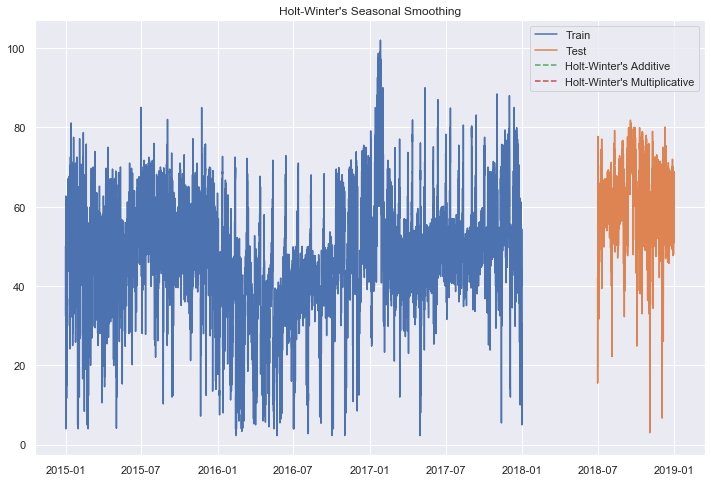

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(daily_train['price day ahead'], trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(daily_train['price day ahead'], trend="mul", seasonal="mul", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast()
fit2 = model2.fit()
pred2 = fit2.forecast()

sse1 = np.sqrt(np.mean(np.square(y.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(y.values - pred2.values)))

plt.show()
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['price day ahead'], label='Train');
plt.plot(test.index, test['price day ahead'], label='Test');
plt.plot(pred, linestyle='--', label="Holt-Winter's Additive".format(sse1, fit.aic));
plt.plot(pred2, linestyle='--', label="Holt-Winter's Multiplicative".format(sse2, fit2.aic)); 
plt.legend(loc= 'best');
plt.title("Holt-Winter's Seasonal Smoothing");